# **CNN?**

🔹&nbsp;**신경망 구조, Neural Network**
-

사람의 뇌 구조에서 영감을 받아 만들어진 머신러닝 모델의 한 형태로, 다음 3가지의 레이어로 구성됩니다 :

- 입력층 (Input layer) : 예측에 필요한 정보를 입력받는 층
- 은닉층 (Hidden layer) : 여러 계산 노드(뉴런)가 연결되어 입력을 가공, 특징(Feature)을 추출하는 층
- 출력층 (Output layer) : 최종 예측 결과를 출력하는 층

이처럼 신경망은 입력값을 받아 여러 단계(레이어)를 거치는 계산 구조이며 그 깊이에 따라 단순한 문제부터 복잡한 문제까지 폭넓게 적용할 수 있습니다.

🔹&nbsp;**합성곱 신경망, Convolution Neural Network**
-

CNN은 이 신경망 구조를 기반으로 만들어졌으며, 이미지 처리에 특화된 계층 구조(합성곱, 풀링 등)를 도입했다는 점에서 일반 신경망과 구분됩니다.

기존 신경망은 이미지의 모든 픽셀을 한 줄로 펼쳐서 처리하기 때문에 그 형태나 공간을 반영하지 어렵다는 단점이 있습니다.

CNN은 이미지를 2차원 구조 그대로 유지하면서 형상, 패턴, 윤곽선 같은 중요한 시각적 특징을 자동으로 추출할 수 있습니다.

이러한 특징 덕분에 CNN은 이미지 분류, 얼굴 인식, 자율 주행, 의료 영상 분석 등 다양한 분야에서 폭넓게 활용되고 있습니다.

<img src="https://i.imgur.com/ManUgfq.jpeg" style="height:400px;">

# **0. 환경 설정**

빠른 CNN 학습을 위해선 가상환경이 올바르게 설정되어 있어야 하며,  
특히 GPU 환경에서 학습하면 CPU 학습 대비 속도가 **수십 배 빨라지기 때문에 이를 검토하는 것은 매우 중요**합니다.

아래 코드를 통해 CUDA 버전 호환성, GPU 연결 여부 등을 확인할 수 있습니다 :

In [25]:
import tensorflow as tf

# 1. TensorFlow 버전 확인
print("TF:", tf.__version__)

# 2. 빌드가 CUDA 지원으로 컴파일되었는지 확인
print("Built with CUDA:", tf.test.is_built_with_cuda())

# 3. 전체 장치 목록 확인 → CPU/GPU 장치가 어떻게 잡히는지
print("Devices:", tf.config.list_physical_devices())

# 4. GPU 인식 여부 확인
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# 5. (가능 시) CUDA/cuDNN 버전 확인
info_fn = getattr(tf.sysconfig, "get_build_info", None)
info = info_fn() if info_fn else {}
print("CUDA:", info.get("cuda_version", "N/A"), "cuDNN:", info.get("cudnn_version", "N/A"))

# 6. 간단 연산을 GPU에 올려보기(있을 때만) → 실제로 GPU에 배치되는지 점검
if gpus:
    with tf.device("/GPU:0"):
        x = tf.random.normal([1024, 1024])
        y = tf.random.normal([1024, 1024])
        z = tf.matmul(x, y)
    print("MatMul device:", z.device)

TF: 2.20.0
Built with CUDA: False
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs: []
CUDA: N/A cuDNN: N/A


False나 N/A가 출력된 경우 : 그래픽 카드의 기종과 CUDA 버전이 호환되지 않을 경우, 잘못된 버전이 설치된 경우 등

Anaconda Prompt에서 아래의 명령어를 순서대로 입력해 현재 cuda 버전을 삭제하고 새로운 버전을 설치해볼 수 있습니다. 

혹는 **아래의 과정을 모두 생략** 하고 **CPU를 이용한 학습을 진행**할 수 있습니다.

**삭제 명령어 :** 

pip uninstall -y tensorflow

conda remove -y cudatoolkit cudnn

**캐시 삭제 명령어 :** 

pip cache purge

**설치 명령어 (새로운 버전 설치 시 사전에 삭제 명령어 반드시 사용) :**

pip install "tensorflow[and-cuda]"

# **1. 데이터 준비 및 전처리**

### 🔹 **데이터 전처리(Preprocessing)** 

모델 학습 전 데이터를 정리하고 가공하는 **모든 준비 과정**을 의미합니다. 
<br>이 작업은 모델이 데이터를 **정확하게 해석하고, 빠르게 수렴하며, 과적합 없이 일반화 성능을 확보**하는 데 핵심적인 역할을 합니다.

### 🔍 **주요 전처리 작업**

- 📦 **데이터 구조 정리** : 클래스별 폴더 정리, 라벨 CSV 작성, 경로 정리
- 🔀 **데이터 분할** : 학습 / 검증 / 테스트 세트로 구분
- 🔢 **수치적 변환** : 이미지 → Tensor 변환, 정규화, 크기 조정 등
- 🔧 **데이터 증강** : 회전, 뒤집기, 자르기 등 변형을 통해 데이터 다양화


### 🧮 **텐서, Tensor**
- 머신러닝에서 사용하는 **다차원 수치 배열 구조 (n차원 행렬)**
- 이미지 데이터는 일반적으로 **3차원 텐서** : [높이(세로 픽셀), 너비(가로 픽셀), 채널(색상)]
- 실제 CNN 학습 시에는 여러 장의 이미지를 한 번에 처리 → **배치(batch)** 차원이 추가
- TensorFlow 기본 형식: [배치 크기, 높이, 너비, 채널] 형태의 **4차원 텐서** 사용

### 💼 **실무 관점**에서의 전처리
실무에서는 **정형화된 공개 데이터셋**보다 직접 수집한 **사용자 정의 데이터(Custom Dataset)** 를 다루는 경우가 많습니다.

이 경우 데이터셋은 다음과 같이 다양할 수 있습니다. 
- 📁 클래스별 폴더 분할 구조
- 📄 CSV 파일 기반 라벨링
- 🔀 파일 경로에 따른 라벨링

따라서 모델 입력 형태에 맞춰 유연하게 전처리 파이프라인을 구성하는 능력이 중요합니다.

# **1.1 단일 이미지 전처리**

TensorFlow(Keras)에서는 `layers`와 `tf.image`를 통해 전처리를 체계적으로 적용할 수 있습니다.

### 🔹 **필수** 전처리 함수 : 모든 프로젝트에 **반드시** 사용

| 전처리 함수 | 설명 | 활용 |
|-------------|------|------|
| `keras.Sequential([...])` | 여러 전처리 작업을 순서대로 묶음 | 전처리 **파이프라인 구성**의 중심 축 역할 |
| `layers.Rescaling(1./255)` | 0-255 픽셀 값을 0-1로 정규화 | 이미지 데이터를 **모델 입력 스케일**로 변환 |
| `layers.Normalization(...)` | 평균 0, 표준편차 1로 표준화 | 학습 **안정성 향상**, 수렴 속도 증가 |
| `layers.Resizing(H, W)` | 이미지를 주어진 크기로 통일 | 입력 크기 **일관성 확보** (모든 입력 동일 크기 보장) |

### ⚙️ **선택적** 전처리 함수 : 데이터 특성에 따라 **유동적**으로 활용

| 전처리 함수 | 설명 | 활용 |
|-------------|------|-----------|
| `layers.RandomFlip("horizontal")` | 이미지 좌우 반전 | 대칭 구조가 유효한 경우에 적합 |
| `layers.RandomRotation(factor)` | 일정 비율(예: `0.1` ≈ 약 ±10°) 내 무작위 회전 | 이미지의 기울어진 촬영에 대비 |
| `layers.RandomCrop(h, w)` | 무작위 위치를 일정 크기로 잘라 사용 | 입력 다양성 확보, 주요 부분 학습 유도 |
| `tf.image.adjust_{brightness,contrast,saturation,hue}` | 밝기/대비/채도/색조 조절 | 조명·카메라 등 환경 변화에 강인함 확보 |
| `layers.RandomCrop + layers.Resizing` | 자르기 + 리사이즈 조합 | 불균형 배경 제거, 중심 영역 학습에 효과적 |
| `tf.image.rgb_to_grayscale` | 흑백으로 변환 | 색상이 중요하지 않거나 1채널 입력이 필요한 경우 |

**⚠️ 주의** : 이미지 파일을 준비하는 단계에서는 **정규화/표준화 결과를 저장** 하면 학습이 원활하게 진행되지 않을 수 있습니다.  
정규화된 값은 이미지 포맷과 스케일이 달라 저장 시 재스케일/클리핑이 발생하고, 그 결과 학습 분포가 깨져 **학습이 비정상적으로 진행**될 수 있습니다.  
이런 정규화/표준화는 **모델에 넣기 직전(학습·예측 시점)** 에만 적용하는 것이 좋습니다.

아래의 코드를 통해 **한 장의 샘플 이미지**에 전처리 함수를 적용해볼 수 있습니다.

C:\Users\RML\anaconda3\envs\cnn_edu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


✅ 이미지 다운로드 완료: dog.jpg
💾 전처리된 이미지 저장 완료: dog_pre.jpg


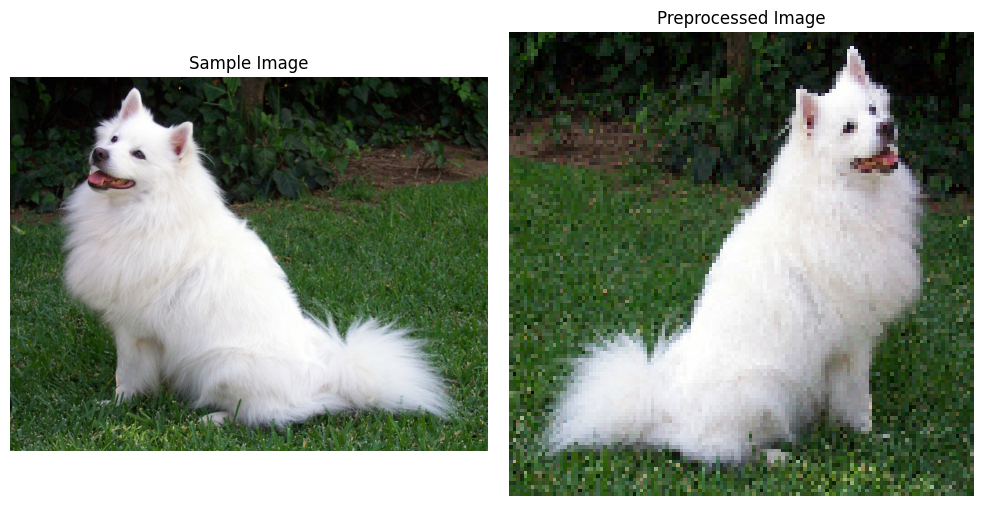

In [1]:
# 1) 경로/폴더
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import requests

# 1. 경로 설정 
root = Path(".").resolve()
save_dir = root / "pre_sample"
save_dir.mkdir(parents=True, exist_ok=True)

image_path  = save_dir / "dog.jpg"      # 원본
output_path = save_dir / "dog_pre.jpg"  # 전처리 결과

# 2) 샘플 이미지 다운로드
if not image_path.exists():
    url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
    r = requests.get(url, stream=True)
    with open(image_path, "wb") as f:
        for chunk in r.iter_content(1024):
            if chunk:
                f.write(chunk)
    print("✅ 이미지 다운로드 완료:", image_path.name)

# 3) 전처리 정의 
IMG_SIZE = (128, 128)

def preprocess_single(img_bytes):
    # 1. 디코드 → RGB (uint8, 0~255)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    # 2. 리사이즈 (float32, 값 범위는 0~255 유지)
    img = tf.image.resize(img, IMG_SIZE)
    # 3. 좌우반전 
    img = tf.image.flip_left_right(img)
    # 4. 저장을 위해 uint8로 변환
    img = tf.clip_by_value(img, 0.0, 255.0)
    img = tf.cast(img, tf.uint8)
    return img

# 4) 전처리 적용 및 저장
orig_bytes = tf.io.read_file(str(image_path))
proc_img = preprocess_single(orig_bytes)                           
encoded = tf.io.encode_jpeg(proc_img, quality=95)
tf.io.write_file(str(output_path), encoded)
print("💾 전처리된 이미지 저장 완료:", output_path.name)

# 5) 전/후 시각화
orig_img = tf.image.decode_image(orig_bytes, channels=3, expand_animations=False)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(orig_img.numpy()); axs[0].set_title("Sample Image"); axs[0].axis("off")
axs[1].imshow(proc_img.numpy()); axs[1].set_title("Preprocessed Image"); axs[1].axis("off")
plt.tight_layout(); plt.show()

# **1.2 폴더 구조 데이터셋 전처리**

앞서 샘플 이미지를 통해 단일 이미지 전처리를 실습했습니다.  

이번에는 **클래스별 하위 폴더 구조를 가진 폴더 기반 데이터셋**을 사용하는 경우, TensorFlow에서 어떻게 전처리를 구성하는지 알아봅니다.

### 💾 폴더 기반 데이터셋 예시

cnn_edu/  
└── data_folder/  
&emsp;&emsp;&emsp;├── dog/  
&emsp;&emsp;&emsp;│&emsp;&emsp;├── dog1.jpg  
&emsp;&emsp;&emsp;│&emsp;&emsp;├── dog2.jpg  
&emsp;&emsp;&emsp;└── cat/  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;├── cat1.jpg  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;├── cat2.jpg

### 📑 주요 활용 함수

| 함수/도구 | 설명 | 활용 |
|---|---|---|
| `tf.keras.utils.image_dataset_from_directory(root, ...)` | **하위 폴더명을 클래스 라벨로 자동 인식**하여 `tf.data.Dataset` 생성 | 폴더 기반 데이터셋 로딩의 핵심 |
| `splitfolders.ratio(...)` | 클래스별 폴더를 **train/val**로 자동 분할 | 데이터셋 분할 자동화 |
| `os.makedirs(path, exist_ok=True)` | 지정 경로 폴더 생성(중복 시 패스) | 출력 폴더 준비 |
| `os.listdir(path)` | 디렉토리 항목 확인 | 구조 점검 및 탐색 |

### 📄 data_folder.zip (feat. Flowers Recognition)

- 총 이미지 **4242장**
- 클래스: **daisy, dandelion, roses, sunflowers, tulips** (5종)

아래의 코드를 통해 폴더 구조 데이터셋을 자동으로 업로드 및 압축 해제하고, 전처리 작업을 통해 학습에 사용 가능한 구조로 변환시킬 수 있습니다.

In [11]:
# -*- coding: utf-8 -*-
# 0) 라이브러리
import os, zipfile, requests
import splitfolders
import tensorflow as tf

# 1) GitHub Release에서 data_folder.zip 다운로드 및 압축 해제
# 1-1. zip 다운로드 → 로컬 저장
url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/download/CNN_release-2025/data_folder.zip"
zip_path = "data_folder.zip"
if not os.path.exists(zip_path):
    with open(zip_path, "wb") as f:
        f.write(requests.get(url).content)

# 1-2. 압축 해제 → data_folder/
extract_dir = "data_folder"
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

print("✅ 압축 해제 완료")
print("📁 폴더 내 파일 목록:", os.listdir(extract_dir))

# 2) 데이터 분할(학습 80%, 검증 20%)
out_dir = "data_folder_split"
if not os.path.exists(out_dir):
    splitfolders.ratio(
        input=extract_dir,
        output=out_dir,
        seed=42,
        ratio=(.8, .2)   # 학습 80%, 검증 20%
    )

print("✅ 학습/검증 데이터 분할 완료")
print("📁 data_folder_split 폴더 구조:", os.listdir(out_dir))

# 3) TensorFlow 데이터셋 구성 (ImageFolder 대체)
#    - image_dataset_from_directory: 하위 폴더명을 클래스 라벨로 자동 매핑
IMG_SIZE  = (128, 128)
BATCH     = 32
AUTOTUNE  = tf.data.AUTOTUNE
DIR_TRAIN = os.path.join(out_dir, "train")
DIR_VAL   = os.path.join(out_dir, "val")

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DIR_TRAIN,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DIR_VAL,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

# 3-1) ⚠️ class_names는 가공(map/cache/prefetch) 전에 추출
class_names = train_ds_raw.class_names
print("📚 클래스 목록:", class_names)

# 4) 전처리 파이프라인 (정규화 + 성능옵션)
# 4-1) [0,255] → [0,1] 스케일
normalizer = tf.keras.layers.Rescaling(1./255)

def preprocess(x, y):
    # 1) 크기/타입은 image_dataset_from_directory가 보장
    # 2) 정규화 → 모델 입력 안정화
    x = normalizer(x)
    return x, y

train_ds = (
    train_ds_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()            # 작은 데이터셋이면 메모리 캐시 권장
    .prefetch(AUTOTUNE) # CPU ↔ GPU 파이프라인 비동기화
)

val_ds = (
    val_ds_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

✅ 압축 해제 완료
📁 폴더 내 파일 목록: ['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']
✅ 학습/검증 데이터 분할 완료
📁 data_folder_split 폴더 구조: ['train', 'val']
Found 2934 files belonging to 5 classes.
Found 736 files belonging to 5 classes.
📚 클래스 목록: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **1.3 복잡 구조 데이터셋 전처리**

실무 환경에서는 이미지와 라벨이 분리되거나 구조가 복잡한 **사용자 정의 데이터(Custom Dataset)** 를 자주 다룹니다.  
따라서 목적에 맞게 데이터를 **유연하게 불러오고 전처리**하는 능력이 필요합니다.

### 📌 복잡한 데이터 구조?

- 📦 이미지와 라벨이 **분리된** 구조: 이미지 파일은 한 폴더, 라벨은 CSV/JSON 등 별도 파일 → 해당 파일에서 라벨을 매핑
- 🏷 라벨이 숫자가 아닌 **문자열**: "dog", "cat" 등 문자열 → **정수 인덱스**로 변환 필요
- 🔀 경로가 **불규칙/중첩**: 하위 디렉토리 다단 구성 → 경로를 고려한 전처리 로직 필요

### 📑 주요 활용 함수/도구

| 함수/도구 | 설명 | 활용 |
|---|---|---|
| `pandas.read_csv()` | CSV의 라벨/경로 메타를 읽어 테이블 구성 | 이미지–라벨 매핑 테이블 생성 |
| `os.path.join()` | 경로 안전 결합 | 이미지 **절대/상대 경로** 만들기 |
| `tf.io.read_file()` | 파일을 바이너리로 읽기 | 이미지 로딩의 1단계 |
| `tf.image.decode_jpeg()` | JPEG/PNG 등 디코딩 | 텐서 이미지 생성 |
| `tf.image.resize()` | 크기 통일 | 입력 크기 표준화 |
| `tf.data.Dataset.from_tensor_slices()` | (경로, 라벨) → Dataset | **커스텀 입력 파이프라인**의 시작 |
| `dataset.map(fn, num_parallel_calls=AUTOTUNE)` | 전처리/증강 함수 적용 | 파이프라인 구성 |
| `dataset.cache().prefetch(AUTOTUNE)` | 성능 최적화 | CPU↔가속기 파이프라인 병목 완화 |
| `sklearn.preprocessing.LabelEncoder` *또는* `pandas.Categorical` | 문자열 라벨 → 정수 인덱스 | 클래스 인덱스 정리 |

### **📄 data_csv.zip (feat. Masked MS-COCO Dataset)**

- 총 **25,000장** (학습 20,000 / 검증 5,000)
- 클래스(10종): `person, airplane, train, bird, dog, elephant, zebra, giraffe, toilet, clock`
- **train_val.csv** 컬럼
  - `image_name` : 이미지 파일 이름
  - `label` : 라벨 **정수** 인덱스
  - `semantic_label` : 라벨 **문자열** 이름
  - `partition` : `train` / `val`
  - 
### 🔧 전처리/샘플링 전략

1) **CSV 로드 → 경로 생성**  
2) **문자열 라벨 → 정수 인덱스**(CSV의 `label` 사용 또는 `semantic_label` 인코딩)  
3) **분포 유지 샘플링**: `partition`×`class` 그룹 비율을 유지하며 샘플링  
4) **tf.data 파이프라인**:  
   - 파일 읽기 → 디코딩 → 리사이즈 → 정규화(0~1)  
   - `cache()` + `prefetch(AUTOTUNE)`로 속도 ↑  
   - (선택) `RandomFlip/Rotation` 등 **증강 레이어** 추가 가능

아래의 코드에서는 **전처리**뿐 아니라 전체 25,000장을 **15,000장으로 샘플링**하는 실습도 포함합니다.

In [6]:
import os, zipfile, shutil
import requests
import pandas as pd
from PIL import Image
import concurrent.futures as cf
import tensorflow as tf

# 0) 학습과 동일하게 맞출 입력 크기
IMG_SIZE = (128, 128)

# 1. GitHub Release에서 data_csv.zip 다운로드 및 압축 해제
url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/download/CNN_release-2025/data_csv.zip"

with open("data_csv.zip", "wb") as f:
    f.write(requests.get(url).content)

with zipfile.ZipFile("data_csv.zip", 'r') as zip_ref:
    zip_ref.extractall("data_csv")

print("✅ 압축 해제 완료")
print("📁 폴더 내 파일 목록:", os.listdir("data_csv"))

# 2. CSV 파일 불러오기
df = pd.read_csv("data_csv/train_val.csv")
df.columns = df.columns.str.strip()

# 2-1. 실제 존재하는 파일만 사용
img_src   = "data_csv/images"
mask_src  = "data_csv/masks"
present   = {f for f in os.listdir(img_src) if os.path.isfile(os.path.join(img_src, f))}
df = df[df["image_name"].astype(str).isin(present)].reset_index(drop=True)

# 3. 클래스 균등 샘플링 (총 15000장: train 12000 / val 3000)
n_train, n_val = 12000, 3000
n_classes = df['label'].nunique()
train_per_class = n_train // n_classes
val_per_class   = n_val // n_classes

train_df = (df[df['partition'] == 'train']
            .groupby('label', group_keys=False)
            .sample(n=train_per_class, random_state=42))
val_df   = (df[df['partition'] == 'val']
            .groupby('label', group_keys=False)
            .sample(n=val_per_class, random_state=42))

df_sampled = pd.concat([train_df, val_df]).reset_index(drop=True)

print("✅ 균등 샘플링 완료")
print("📊 클래스 수:", n_classes)
print("🖼️ 샘플 총 이미지 수:", len(df_sampled), "(train 12000 / val 3000)")

# 4. 샘플링된 이미지/마스크 복제 → images_sampled & masks_sampled 폴더 생성
img_dst  = "data_csv/images_sampled"
mask_dst = "data_csv/masks_sampled"
for d in [img_dst, mask_dst]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# 5. TensorFlow 기반 전처리 함수 정의
def _save_processed_image(src_path, dst_path):
    """이미지 리사이즈 후 저장 (TensorFlow → PIL 변환)"""
    img_raw = tf.io.read_file(src_path)
    img = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.uint8).numpy()
    Image.fromarray(img).save(dst_path)

def _save_resized_mask(src_path, dst_path):
    """마스크는 최근접 보간으로 리사이즈"""
    with Image.open(src_path) as mk:
        mk = mk.resize(IMG_SIZE, Image.NEAREST)
        mk.save(dst_path)

print("✅ 데이터 전처리 준비 완료")

# 6. 작업 리스트 구성
tasks = []
for fname in df_sampled["image_name"]:
    si = os.path.join(img_src, fname); di = os.path.join(img_dst, fname)
    tasks.append(("img", si, di))
    sm = os.path.join(mask_src, fname); dm = os.path.join(mask_dst, fname)
    if os.path.isfile(sm):
        tasks.append(("mask", sm, dm))

def _do(task):
    kind, s, d = task
    if not os.path.isfile(s):
        return
    if kind == "img":
        _save_processed_image(s, d)
    else:
        _save_resized_mask(s, d)

# 병렬 처리
with cf.ThreadPoolExecutor(max_workers=12) as ex:
    list(ex.map(_do, tasks))

print(f"📂 images_sampled 생성: {len(os.listdir(img_dst))}개")
print(f"📂 masks_sampled  생성: {len(os.listdir(mask_dst))}개")

# 7. 샘플링 결과 CSV 저장
os.makedirs("data_csv/meta", exist_ok=True)
train_df.to_csv("data_csv/meta/train_sampled.csv", index=False)
val_df.to_csv("data_csv/meta/val_sampled.csv", index=False)
df_sampled.to_csv("data_csv/meta/train_val_sampled.csv", index=False)
print("📝 샘플링 CSV 저장 완료")


✅ 압축 해제 완료
📁 폴더 내 파일 목록: ['images', 'masks', 'train_val.csv']
✅ 균등 샘플링 완료
📊 클래스 수: 10
🖼️ 샘플 총 이미지 수: 15000 (train 12000 / val 3000)
✅ 데이터 전처리 준비 완료
📂 images_sampled 생성: 15000개
📂 masks_sampled  생성: 15000개
📝 샘플링 CSV 저장 완료


# **1.4 별도 파일 구조 데이터셋**

실무에서는 CSV뿐 아니라 **JSON, YAML 등 별도의 파일 형식**으로 라벨이 제공되는 경우도 많습니다.  
이 경우에는 일반적인 `ImageFolder`나 단순 CSV 로딩만으로는 데이터를 바로 사용할 수 없고, **별도 파서(Parser)를 구현**해야 합니다. 

*파서 : 원본 데이터를 읽어서 쓸 수 있는 형태로 변환해주는 코드

#### **🔹 JSON 예시**
```json
{
  "annotations": [
    {"image_id": "0001.jpg", "category_id": 3, "category_name": "dog"},
    {"image_id": "0002.jpg", "category_id": 1, "category_name": "cat"}
  ]
}
```
#### **🔹 YAML 예시**
```yaml
train: data/images/train
val: data/images/val
names:
  0: person
  1: car
  2: dog
```

### 📌 **별도 파일 구조의 특징**

- 📂 **이미지와 라벨 파일 분리** : 이미지 폴더와 JSON/YAML 라벨 파일이 별도 제공됨  
- 📑 **라벨의 계층적 구조** : JSON은 중첩된 dictionary, YAML은 key-value 구조를 가짐
- 🎛️ **다중 속성 가능성** : 상황에 따라 데이터가 다양한 부가 속성이 존재할 수 있으며, 이 경우 매우 복잡 
- 🔄 **유연한 파싱 필요** : 데이터셋 제작자마다 라벨링 규칙이 달라 코드 적응 필요

### 📑 **주요 활용 함수**

| 함수/모듈 | 설명 | 활용 |
|-----------|------|------|
| `json.load(f)` | JSON 파일 불러오기 | json 기반 라벨 파싱 |
| `yaml.safe_load(f)` | YAML 파일 불러오기 | yaml 기반 구조 읽기 |
| `dict` / `list` 탐색 | 중첩된 라벨 구조 접근 | annotation → category 등 매핑 |
| `os.path.join()` | 경로 조합 | 이미지 전체 경로 생성 |
| `tf.data.Dataset.from_tensor_slices()` | TensorFlow Dataset 생성 | 파싱된 (이미지경로, 라벨) 매핑을 Dataset으로 변환 |

### ⚙️ **전처리 절차**

1. JSON 또는 YAML 파일 로드 (`json` / `yaml` 모듈 사용)  
2. 이미지 파일명과 라벨 정보를 매핑 (dictionary 활용)  
3. 필요 시 문자열 라벨을 숫자로 인코딩 (LabelEncoder 등)  
4. `(경로, 라벨)` 데이터를 `tf.data.Dataset.from_tensor_slices()`로 변환  
5. `map()`으로 이미지 읽기/리사이즈/정규화 전처리 적용  
6. `batch()`, `cache()`, `prefetch()`를 연결하여 학습 파이프라인 구성

일반적으로, 개별 파일 형식으로 저장된 데이터셋은 그 구조가 매우 복잡합니다. 
즉, 해당 데이터를 불러오고 전처리하는 코드 또한 매우 복잡해지고 이러한 데이터셋으로 모델 학습 코드를 **비숙련자가 작성하기에는 많은 어려움**이 있습니다.

따라서 이번 단계에서는 하나의 json **해당 구조가 존재한다는 점**과 **위 절차를 따라 전처리가 진행되는 점** 정도만 이해하시면 되겠습니다. 

# **2. 모델 아키텍처**

학습에 사용할 데이터를 모두 준비 완료하였습니다. 이제 이를 학습할 CNN 모델을 설정해 보겠습니다.

### 🧱 CNN 모델 아키텍처의 **기본 구성 요소**

1. **Convolution Layer (합성곱 계층)**

   - 입력 이미지 위를 **작은 필터(커널, kernel)** 가 **슬라이딩**하며 **특징(feature)** 추출  
   - 각각의 필터는 특정 종류의 피처를 감지 (엣지, 패턴 등)  
   - TensorFlow: `tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation)`

2. **Activation Function (활성화 함수)**

   - 각 층의 출력값에 **비선형성을 부여**하여 복잡한 패턴을 학습할 수 있게 만듦  
   - 가장 널리 쓰이는 예시는 **ReLU (Rectified Linear Unit)**:  
     수식 𝑓(𝑥) = max(0, 𝑥) → 음수 제거, 양수 유지  
   - 그 외에도 **LeakyReLU, Tanh, Sigmoid, GELU, SiLU** 등 다양한 함수 사용 가능  
   - 주로 **합성곱 계층** 과 **완전 연결층(Dense)** 뒤에 배치  
   - TensorFlow: `activation="relu"` 또는 `layers.ReLU()`

3. **Pooling Layer (풀링 계층)**

   - 각 계층 영역에서 **최댓값(MaxPooling2D)** 또는 **평균값(AveragePooling2D)** 등을 선택  
   - 피처 맵의 크기를 줄이고 **중요한 정보만 유지**  
   - 같은 물체가 이미지의 다른 위치에 있더라도 핵심 특징만 남겨 **위치 변화에도 강인함 확보**  
   - TensorFlow: `tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)`

4. **Feature Aggregation (피처 집계)** 

   - 완전 연결층에 넣기 전 **피처 맵을 정리**하는 마지막 단계  
   - 모델의 성능, 목적에 따라 **유동적으로** 구성  
   - 예) **Flatten**: 2D 특성맵을 1D 벡터로 펼침 → 많은 피처 학습 가능하지만 모델 복잡도 증가  
   - TensorFlow: `tf.keras.layers.Flatten()`

5. **Fully Connected Layer (완전 연결층, Dense)**

   - 집계된 특징 벡터를 받아 출력 클래스 수에 맞게 **점수 계산**  
   - 모든 노드를 연결해 **최종 분류** 수행  
   - TensorFlow: `tf.keras.layers.Dense(units, activation)`

---

### 🔍 CNN 레이어 흐름 정리

```text
입력 이미지 Tensor 
(예: batch=16, RGB=3, 32x32 이미지 → [16, 32, 32, 3])   # TensorFlow: [batch, height, width, channels]
 ↓
[Conv2D + 활성화 함수] → 특징 추출
 ↓
[MaxPooling2D] → 중요 특징 유지 + 연산 축소
 ↓
[Conv2D + 활성화 함수 + Pooling] → 여러 계층을 반복 (깊이 증가)
 ↓
[Feature Aggregation] → 피처 맵을 집계해 Dense 층에 전달
 ↓
[Dense + 활성화 함수] → 각 클래스에 대한 점수 계산
 ↓
출력
```
이처럼 CNN은 입력 이미지를 계층적으로 처리하며, 점점 고차원의 복잡한 특징을 추출하여 최종 분류를 수행할 수 있도록 합니다.


# **2.1 CNN 계층 파라미터**

### 🧩 파라미터란?

모델을 만들 때에는 사람이 **직접 설정해주는 값**이 있습니다.  
이러한 값들을 **파라미터(hyperparameter)** 라고 부릅니다.

- 모델이 **학습하면서 자동으로 찾는 값**은 '가중치(weight)'  
- 반면, 사람이 **미리 설정해줘야 하는 값**은 '파라미터'

즉, 파라미터는 **모델의 구조와 동작 방식을 결정하는 설정값**이라 할 수 있습니다.

---

### 🧱 CNN에서 중요한 하이퍼파라미터
<br>

🔹**합성곱 계층(tf.keras.layers.Conv2D)**

| 항목 | 예시 | 의미 | 모델에 미치는 영향 |
|------|------|------|-------------------|
| 입력 채널 수 (`input_shape`) | (128,128,3) | 입력 이미지의 크기와 채널 수 (흑백:1, RGB:3) | 모델 입력 형식을 정의 |
| 출력 채널 수 (`filters`) | 16 | 필터 개수 ( = 추출할 특징 종류 수) | 값이 크면 모델 표현력과 파라미터 수 증가, 연산량 증가 |
| 필터 크기 (`kernel_size`) | 3 | 합성곱 영역의 크기 (예: 3x3) | 작을수록 세밀한 특징, 클수록 넓은 구조 감지 |
| 스트라이드 (`stride`) | 1 | 합성곱 필터 이동 간격 | 출력 크기 축소, 연산량 감소 |
| 패딩 (`padding`) | 1 | 입력 가장자리에 0을 추가해 크기 유지 | 출력 크기를 입력과 맞추거나, 정보 손실 방지 목적 |
| 활성화 함수 | ReLU 등 | 출력값에 비선형성을 부여 | 복잡한 패턴 학습 가능 |

<br>

🔹**풀링 계층(tf.keras.layers.MaxPooling2D / AveragePooling2D)**

| 항목 | 예시 | 의미 | 모델에 미치는 영향 |
|------|------|------|-------------------|
| 풀링 종류 | Max / Average | 대표값을 선택하는 방식 결정 | Max : 뚜렷한 특징 강조 / Average : 전체 정보를 부드럽게 요약 |
| 필터 크기 (`kernel_size`) | 2 | 풀링할 영역의 크기 (예: 2x2) | 큰 크기는 더 넓은 영역을 요약하여 출력 크기 감소 |
| 스트라이드 (`stride`) | 2 | 풀링 필터 이동 간격 | 출력 크기와 요약 정도 결정. 크면 정보 압축률이 높아짐 |
| 패딩 (`padding`) | 0 | 입력 가장자리에 0을 추가해 크기 유지 | 거의 사용하지 않음. 출력 크기 보정 시 예외적으로 사용됨 |

<br>

🔹**Flatten 계층(tf.keras.layers.Flatten)**

- 파라미터는 없지만, 뒤에 연결될 완전 연결층의 입력 크기를 결정 : 모든 값을 곱해 1D 값으로 변환

<br>

🔹 **완전 연결층 (Dense, 완전 연결층)**

| 항목 | 예시 | 의미 | 모델에 미치는 영향 |
|------|------|------|-------------------|
| 입력 피처 수 (`in_features`) | 2048 | Flatten 결과의 길이 (Flatten 계층의 출력 크기) | 정확히 일치하지 않으면 오류 발생 |
| 출력 피처 수 (`out_features`) | 10 | 분류할 클래스 수 또는 중간 노드 수 | 클래스 수에 따라 출력 크기 결정, 분류 성능 및 모델 복잡도에 영향 |
| 활성화 함수 | ReLU 등 | 출력값에 비선형성을 부여 | 학습 가능한 복잡한 패턴 표현, 분류 결과 해석에 영향 |


---

### 🔍 예시 코드

```python
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, kernel_size=3, strides=1, padding="same",
                  activation="relu", input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(32, kernel_size=3, strides=1, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Flatten(),                        # 피처 맵 집계
    layers.Dense(128, activation="relu"),    # 은닉층
    layers.Dense(10, activation="softmax")   # 출력층 (10개 클래스)
])

model.summary()
```

# **2.2 출력 크기 계산**

입력 이미지는 **합성곱 계층(Conv2d)** 과 **풀링 계층(Pool2d)** 을 통과할 때마다, 각 계층의 설정에 따라 출력 크기가 달라집니다.

### 🧮 출력 크기 계산식
#### $H_{out} = \left\lfloor \frac{H_{in} + 2P_H - K_H}{S_H} \right\rfloor + 1$

#### $W_{out} = \left\lfloor \frac{W_{in} + 2P_W - K_W}{S_W} \right\rfloor + 1$

- $H_{in}, W_{in}$ : 입력 이미지의 높이 / 너비  
- $K_H, K_W$ : 필터(커널)의 높이 / 너비  
- $S_H, S_W$ : 스트라이드 (높이/너비 방향 이동 간격)  
- $P_H, P_W$ : 패딩 (상하/좌우 여백)   

#### 🧪 **예시: 입력 이미지 크기 [3, 128, 96] , 2계층 CNN**

2계층 CNN 구성:

**#1**  
1️⃣ Conv2d(3, 16, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1)  
2️⃣ MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

**#2**  
1️⃣ Conv2d(16, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))  
2️⃣ MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

**#3**  
1️⃣ Flatten()  
2️⃣ Linear(32 × 32 × 24, 128)  
3️⃣ Linear(128, 10) → 최종 출력

| 계층           | 입력 크기       | 커널 / 스트라이드 / 패딩 | 계산식                                                                 | 출력 크기     | 채널 변화   |
|----------------|------------------|----------------------------|--------------------------------------------------------------------------|----------------|----------------|
| Conv2d  #1-1    | 128 × 96         | 5×3 / 1×1 / 2×1            | H: (128 + 2×2 − 5)/1 + 1 = **128**<br>W: (96 + 2×1 − 3)/1 + 1 = **96**  | 128 × 96       | 3 → 16         |
| MaxPool #1-2    | 128 × 96         | 2×2 / 2×2 / 0×0            | H: (128 − 2)/2 + 1 = **64**<br>W: (96 − 2)/2 + 1 = **48**               | 64 × 48        | 16 → 16        |
| Conv2d  #2-1    | 64 × 48          | 3×5 / 1×1 / 1×2            | H: (64 + 2×1 − 3)/1 + 1 = **64**<br>W: (48 + 2×2 − 5)/1 + 1 = **48**    | 64 × 48        | 16 → 32        |
| MaxPool #2-2    | 64 × 48          | 2×2 / 2×2 / 0×0            | H: (64 − 2)/2 + 1 = **32**<br>W: (48 − 2)/2 + 1 = **24**                | 32 × 24        | 32 → 32        |
| Flatten #3-1    | [32, 32, 24]     | -                          | 32 × 32 × 24 = **24576**                                                | 24576          | -              |
| Dense  #3-2    | 24576            | -                          | 24576 → **128**                                                             | 128            | 24576 → 128    |
| Dense  #3-3    | 128              | -                          | 128 → **10**                                                                | 10             | 128 → 10       |


최종 출력 : **[10]** 개의 클래스에 대한 점수

아래의 코드를 실행해 출련 크기 계산 예제를 생성하고 풀어볼 수 있습니다.

In [10]:
import random
from dataclasses import dataclass

def conv_out_size(n_in, k, s, p):  # ⌊(n_in + 2p − k)/s⌋ + 1
    return (n_in + 2 * p - k) // s + 1

def pool_out_size(n_in, k, s, p=0):  # ⌊(n_in + 2p − k)/s⌋ + 1
    return (n_in + 2 * p - k) // s + 1

@dataclass
class QuizSpec:
    C_in: int; H: int; W: int
    conv_in: int; conv_filters: int
    k: int; s: int; p: int
    pool_k: int; pool_s: int; pool_p: int

def sample_quiz():
    side = random.choice([64, 96, 112, 128, 160])  # 정사각 입력
    C_in = 3
    k = random.choice([3, 5, 7])
    s = random.choice([1, 2])
    # k가 정해진 뒤 p 결정 (70%는 k//2, 아니면 0/1/2/3 중 무작위)
    p = k // 2 if random.random() < 0.7 else random.choice([0, 1, 2, 3])
    return QuizSpec(
        C_in=C_in, H=side, W=side, conv_in=C_in,
        conv_filters=random.choice([8, 16, 32, 48, 64]),
        k=k, s=s, p=p,
        pool_k=2, pool_s=2, pool_p=0
    )

def compute_flatten_length(spec: QuizSpec):
    H1 = conv_out_size(spec.H, spec.k, spec.s, spec.p)
    W1 = conv_out_size(spec.W, spec.k, spec.s, spec.p)
    C1 = spec.conv_filters
    H2 = pool_out_size(H1, spec.pool_k, spec.pool_s, spec.pool_p)
    W2 = pool_out_size(W1, spec.pool_k, spec.pool_s, spec.pool_p)
    C2 = C1
    return (H1, W1, C1, H2, W2, C2, C2 * H2 * W2)

def explain_conv_pool(spec: QuizSpec, H1, W1, C1, H2, W2, C2):
    h_div = (spec.H + 2 * spec.p - spec.k) // spec.s
    w_div = (spec.W + 2 * spec.p - spec.k) // spec.s
    h2_div = (H1 + 2 * spec.pool_p - spec.pool_k) // spec.pool_s
    w2_div = (W1 + 2 * spec.pool_p - spec.pool_k) // spec.pool_s
    print("\n[중간 단계 확인: 상세 계산]")
    print(f"- Conv2D (Channels: {spec.conv_in}→{C1}, Kernel: {spec.k}x{spec.k}, Strides: {spec.s}x{spec.s}, Padding(px): {spec.p}x{spec.p})")
    print(f"  · Height 계산: ({spec.H} + 2×{spec.p} - {spec.k})/{spec.s} +1 = {h_div} +1 = {h_div+1}  # 최종 Height={H1}")
    print(f"  · Width  계산: ({spec.W} + 2×{spec.p} - {spec.k})/{spec.s} +1 = {w_div} +1 = {w_div+1}  # 최종 Width={W1}")
    print(f"- MaxPooling2D (Channels: {C1}→{C2}, Pool: {spec.pool_k}x{spec.pool_k}, Strides: {spec.pool_s}x{spec.pool_s}, Padding(px): {spec.pool_p}x{spec.pool_p})")
    print(f"  · Height 계산: ({H1} + 2×{spec.pool_p} - {spec.pool_k})/{spec.pool_s} +1 = {h2_div} +1 = {h2_div+1}  # 최종 Height={H2}")
    print(f"  · Width  계산: ({W1} + 2×{spec.pool_p} - {spec.pool_k})/{spec.pool_s} +1 = {w2_div} +1 = {w2_div+1}  # 최종 Width={W2}")
    print(f"- Flatten 계산: Channels({C2}) × Height({H2}) × Width({W2}) = {C2} × {H2} × {W2} = {C2*H2*W2}")

def make_distractors(correct, H1, W1, H2, W2, spec: QuizSpec):
    cand = {correct}
    H1_pad0 = conv_out_size(spec.H, spec.k, spec.s, 0)
    W1_pad0 = conv_out_size(spec.W, spec.k, spec.s, 0)
    H2_pad0 = pool_out_size(H1_pad0, spec.pool_k, spec.pool_s, spec.pool_p)
    W2_pad0 = pool_out_size(W1_pad0, spec.pool_k, spec.pool_s, spec.pool_p)
    cand.add(max(1, spec.conv_filters * H2_pad0 * W2_pad0))         # a) 패딩 0 가정
    cand.add(max(1, spec.conv_filters * H1 * W1))                   # b) 풀링 누락
    H1_s1 = conv_out_size(spec.H, spec.k, 1, spec.p)                # c) stride=1 착각
    W1_s1 = conv_out_size(spec.W, spec.k, 1, spec.p)
    H2_s1 = pool_out_size(H1_s1, spec.pool_k, spec.pool_s, spec.pool_p)
    W2_s1 = pool_out_size(W1_s1, spec.pool_k, spec.pool_s, spec.pool_p)
    cand.add(max(1, spec.conv_filters * H2_s1 * W2_s1))

    area = max(1, H2 * W2)
    jitter = max(1, area // 8)
    cand.update({max(1, correct + jitter), max(1, correct - jitter),
                 max(1, correct // 2), max(1, correct * 2)})

    lst = list(cand); random.shuffle(lst)
    if len(lst) >= 4:
        wrong = [x for x in lst if x != correct]; random.shuffle(wrong)
        out = [correct] + wrong[:3]; random.shuffle(out); return out
    while len(lst) < 4:
        delta = random.randint(1, max(2, area // 4))
        lst.append(max(1, correct + random.choice([-delta, delta])))
    if correct not in lst: lst[0] = correct
    random.shuffle(lst); return lst

def print_quiz_and_get_answer(spec: QuizSpec):
    H1, W1, C1, H2, W2, C2, flat = compute_flatten_length(spec)
    print("=== CNN 출력 크기 4지선다 퀴즈 (TensorFlow 스타일) ===")
    print(f"입력 텐서 (Height, Width, Channels) = [{spec.H}, {spec.W}, {spec.C_in}]  # NHWC, RGB")
    print(f"Conv2D: filters={spec.conv_filters}, kernel={spec.k}x{spec.k}, strides={spec.s}x{spec.s}, padding(px)={spec.p}x{spec.p}")
    print(f"MaxPool2D: pool={spec.pool_k}x{spec.pool_k}, strides={spec.pool_s}x{spec.pool_s}, padding(px)={spec.pool_p}x{spec.pool_p}")
    print("계층 흐름: Conv2D → MaxPool2D → Flatten\n")

    options = make_distractors(flat, H1, W1, H2, W2, spec)
    for i, opt in enumerate(options, 1): print(f"{i}) {opt}")

    try:
        choice = int(input("\n정답 번호(1~4)를 입력하세요: ").strip())
        picked = options[choice - 1]
    except Exception:
        print("입력이 올바르지 않습니다."); return

    print("\n--- 채점 ---")
    print("✅ 정답입니다!" if picked == flat else f"❌ 오답입니다. 정답은 {flat} 입니다.")
    explain_conv_pool(spec, H1, W1, C1, H2, W2, C2)
    print(f"\n[최종 결과]\n- Conv2D 출력 맵: C={C1}, H={H1}, W={W1}\n- MaxPool2D 출력 맵: C={C2}, H={H2}, W={W2}\n- Flatten 길이: {flat}")

# 실행
random.seed(7)
spec = sample_quiz()
print_quiz_and_get_answer(spec)


=== CNN 출력 크기 4지선다 퀴즈 (TensorFlow 스타일) ===
입력 텐서 (Height, Width, Channels) = [112, 112, 3]  # NHWC, RGB
Conv2D: filters=8, kernel=3x3, strides=2x2, padding(px)=1x1
MaxPool2D: pool=2x2, strides=2x2, padding(px)=0x0
계층 흐름: Conv2D → MaxPool2D → Flatten

1) 12544
2) 6174
3) 6272
4) 3136



정답 번호(1~4)를 입력하세요:  3



--- 채점 ---
✅ 정답입니다!

[중간 단계 확인: 상세 계산]
- Conv2D (Channels: 3→8, Kernel: 3x3, Strides: 2x2, Padding(px): 1x1)
  · Height 계산: (112 + 2×1 - 3)/2 +1 = 55 +1 = 56  # 최종 Height=56
  · Width  계산: (112 + 2×1 - 3)/2 +1 = 55 +1 = 56  # 최종 Width=56
- MaxPooling2D (Channels: 8→8, Pool: 2x2, Strides: 2x2, Padding(px): 0x0)
  · Height 계산: (56 + 2×0 - 2)/2 +1 = 27 +1 = 28  # 최종 Height=28
  · Width  계산: (56 + 2×0 - 2)/2 +1 = 27 +1 = 28  # 최종 Width=28
- Flatten 계산: Channels(8) × Height(28) × Width(28) = 8 × 28 × 28 = 6272

[최종 결과]
- Conv2D 출력 맵: C=8, H=56, W=56
- MaxPool2D 출력 맵: C=8, H=28, W=28
- Flatten 길이: 6272


# **3. 계층 설계 및 흐름 분석**

앞선 2장 모델 아키텍처 구성에서는 CNN 계층 파라미터를 조정하고 출력 크기 계산 실습을 완료했습니다.

이번 장에서는 **CNN 계층을 실제로 적용**하는 방법을 배우고 **계층별 출력(Feature Map)을 시각화**하여 피처 맵이 어떻게 생성되는지 확인해보겠습니다.

피처 맵 추출을 위해 **모델 학습 코드가 일부 사용**될 예정이지만, 모델 학습과 관련된 내용은 4장 모델 학습에서 더 자세하게 다룰 것입니다.
<br>이번 장에서는 **계층 설계에 필요한 함수**와 그 사용법을 중점적으로 살펴보겠습니다.

# **3.1 계층 설계 API**

TensorFlow/Keras에서 모델을 설계하는 방법은 크게 **3가지 구조**로 나눌 수 있습니다.  
각 방식은 난이도와 자유도가 다르며, 상황에 맞게 선택할 수 있습니다.

### **1) Sequential API**
- 가장 단순한 방법, 레이어를 순서대로만 연결 가능
- 별도의 함수(`__init__`, `call`) 필요 없음
- 다중 입력/출력, 레이어 공유 같은 비선형 그래프는 표현 어려움

**예시**
```python
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])
```

### **2) Functional API**
- 복잡한 구조(분기, 합류, 다중 입력/출력)를 표현할 수 있음
- `tf.keras.Input`으로 시작해, 레이어를 함수처럼 연결
- 마지막에 `tf.keras.Model(inputs, outputs)`으로 정의

**예시**
```python
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
```

### **3) Subclassing API (사용자 정의 클래스)**
- 가장 자유도가 높은 방식
- 반드시 알아야 하는 함수들:
  - `__init__(self)` : 사용할 레이어 정의
  - `super().__init__()` : 부모 클래스 초기화
  - `call(self, inputs)` : 입력을 받아 순서대로 레이어를 통과시켜 출력 생성
- 복잡한 맞춤형 모델에서 자주 사용

**예시**
- 클래스 `MyCNN(tf.keras.Model)` 정의  
- `__init__()`에서 Conv2D, MaxPooling2D, Flatten, Dense 선언  
- `call()`에서 입력을 순서대로 통과시켜 최종 출력 반환  
```python
class MyCNN(tf.keras.Model):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same")
        self.pool = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)
```

### ✅ 정리
- **Sequential API** → 단순 구조, 사용하기 쉬움  
- **Functional API** → 복잡한 구조 표현 가능  
- **Subclassing API** → 가장 자유로움, 직접 `__init__`, `call()` 구현 필요


# **3.2 피처 맵 추출 및 시각화**

### **🔹 주요 추출 함수**

| 함수/메서드 | 설명 | 활용 |
|-------------|------|------|
| `model(inputs, training=False)` | 모델을 평가 모드로 실행하여 출력값(피처 맵)을 얻음 | 중간 출력 확인, 최종 분류 이전 단계 시각화 |
| `tf.keras.Model(inputs, outputs)` | 기존 모델에서 특정 레이어의 출력을 **새로운 모델의 출력**으로 지정 | 원하는 레이어의 피처 맵만 추출할 때 |
| `layer.output` | Keras 레이어 객체의 출력 텐서 | `tf.keras.Model` 생성 시 중간 레이어 선택에 활용 |
| `tf.stop_gradient(tensor)` | 해당 텐서에 대해 **기울기 계산을 차단** | 피처 맵을 추출할 때 학습 그래프에 불필요하게 연결되지 않도록 함 |
| `model.get_layer(name)` | 모델에서 레이어 이름으로 레이어를 가져옴 | 특정 레이어의 피처 맵을 지정적으로 추출할 때 |

아래의 코드는 **3.1**의 2) Functional API와 주요 추출 함수를 활용하여 피처 맵 추출 및 시각화를 진행하는 함수입니다.
<br>**1.2**의 폴더 기반 데이터셋을 사용하며, 5개의 클래스에 대해 각각 1장의 원본 이미지와 함께 1계층, 2계층을 통과한 피처 맵을 시각화 합니다.

Found 2934 files belonging to 5 classes.


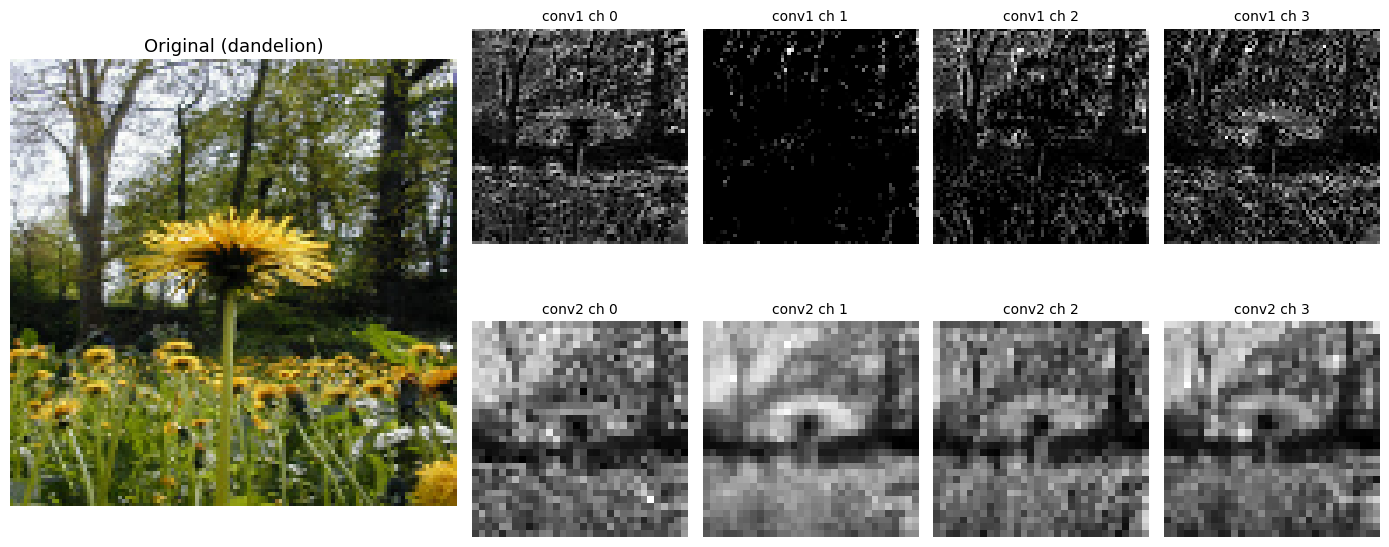

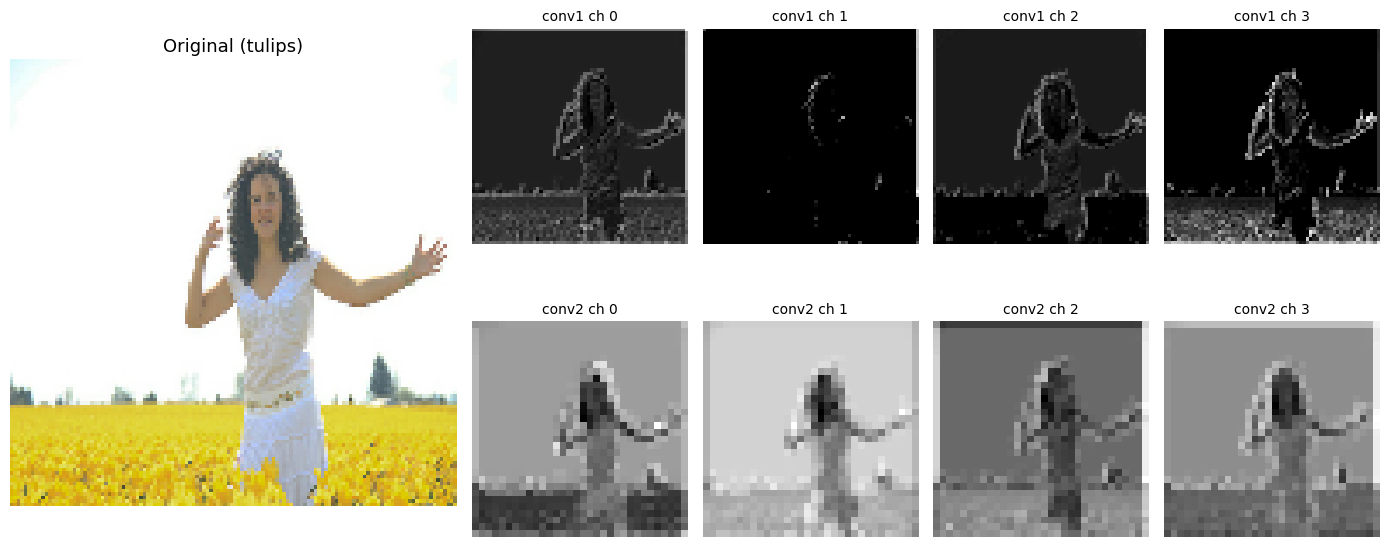

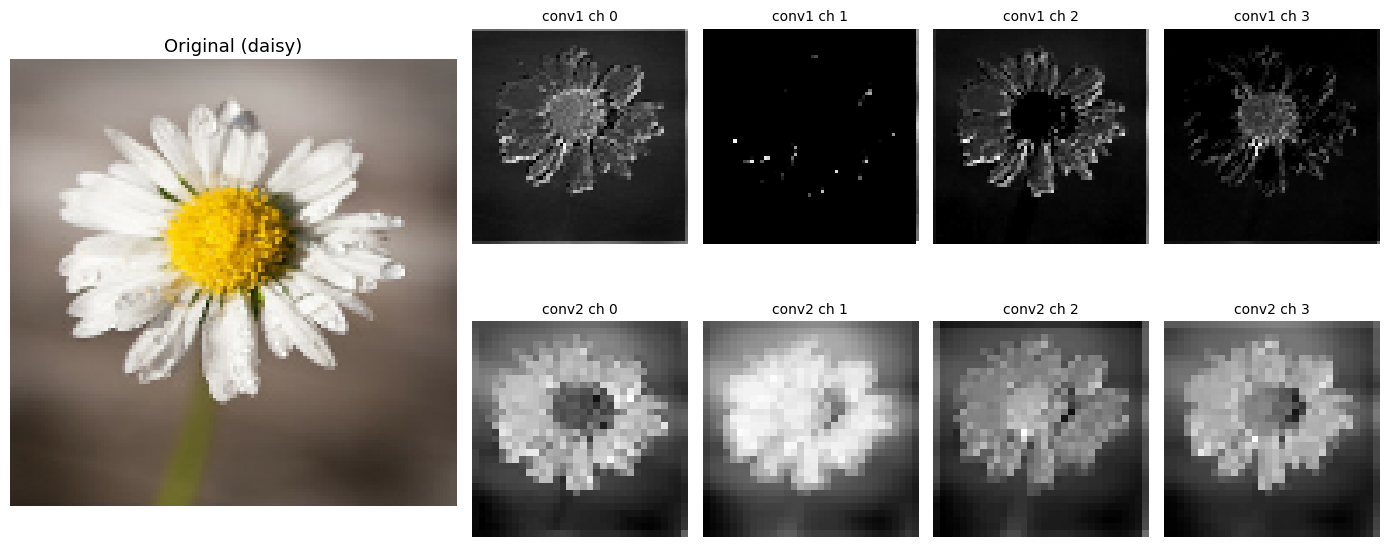

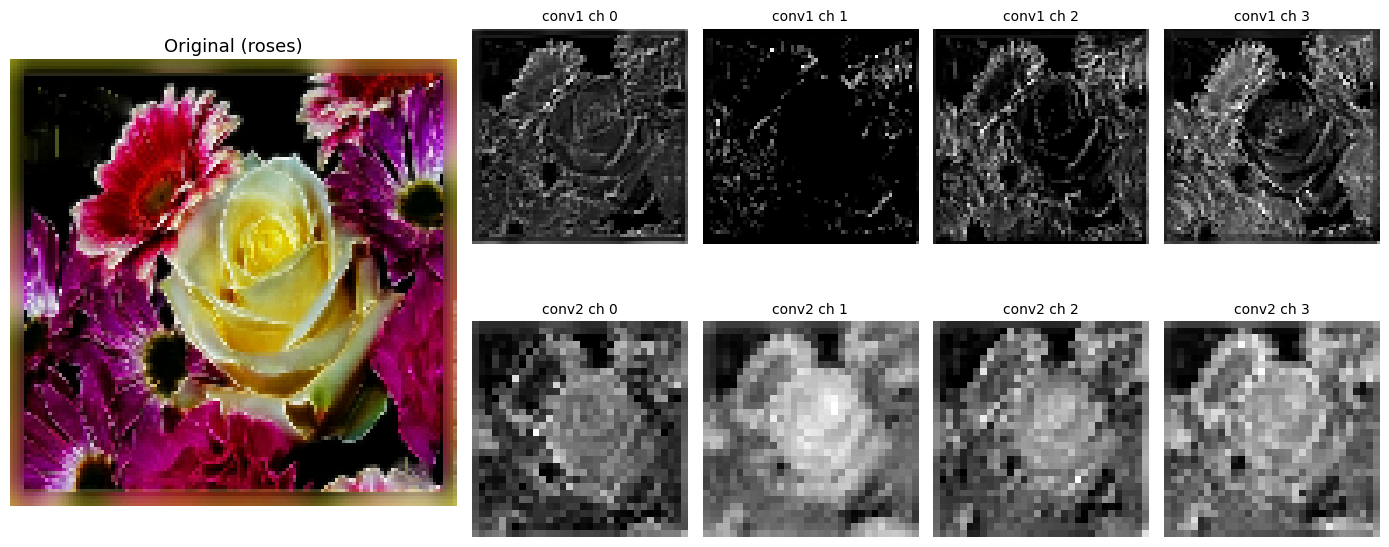

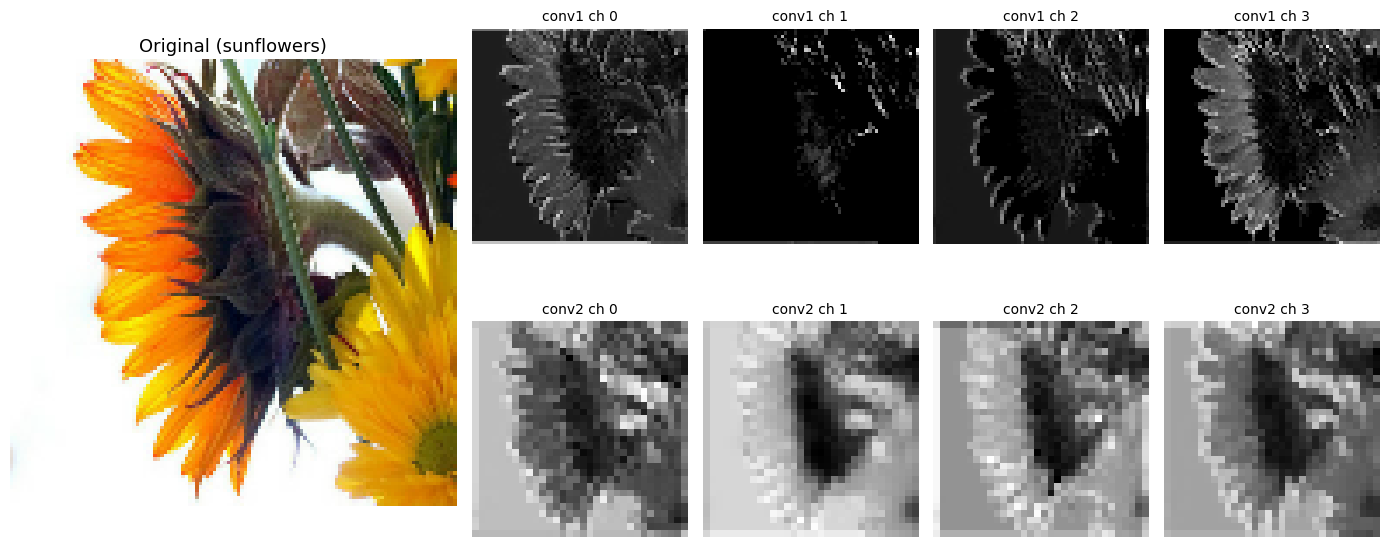

In [26]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec

# 0) 하이퍼파라미터
IMG_SIZE = (128, 128)
BATCH = 128
DIR_TRAIN = "data_folder_split/train"

# 1) 데이터 로딩 (랜덤 셔플로 클래스별 1장 랜덤 선택 효과)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DIR_TRAIN,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=42  # 재현 가능한 랜덤
)
class_names = train_ds_raw.class_names

# 전처리(정규화)
normalizer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalizer(x), y)).prefetch(tf.data.AUTOTUNE)

# 2) 각 클래스에서 1장씩 랜덤 선택 (셔플된 스트림에서 '해당 클래스의 첫 등장' 1장 채택)
picked_imgs, picked_labels = [], []
seen = [False] * len(class_names)
for x, y in train_ds.unbatch().batch(1):
    c = int(y.numpy()[0])
    if not seen[c]:
        picked_imgs.append(x.numpy()[0])  # (H, W, C) in [0,1]
        picked_labels.append(c)
        seen[c] = True
        if all(seen):
            break

images = np.stack(picked_imgs, axis=0)  # (N, H, W, C)
labels = np.array(picked_labels)

# 3) 모델 (Functional API) — 중간 피처맵(feat1, feat2) 출력
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", name="conv1")(inputs)
x = tf.keras.layers.MaxPooling2D(name="pool1")(x)
feat1 = x  # 1계층 피처맵

x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", name="conv2")(x)
x = tf.keras.layers.MaxPooling2D(name="pool2")(x)
feat2 = x  # 2계층 피처맵

feature_model = tf.keras.Model(inputs, [feat1, feat2], name="FeatureExtractor")

# 4) 피처맵 추론 (평가 모드)
fm1, fm2 = feature_model(images, training=False)  # shapes: (N, H1, W1, C1), (N, H2, W2, C2)
fm1 = tf.stop_gradient(fm1)
fm2 = tf.stop_gradient(fm2)

# 5) 시각화 — 왼쪽 큰 원본, 오른쪽 위 1st 4장, 아래 2nd 4장
max_channels = 4   # 각 계층에서 보여줄 채널 수
N = images.shape[0]

for i in range(N):
    label_name = class_names[labels[i]]

    # GridSpec: 2행 × 6열
    fig = plt.figure(figsize=(14, 6))  
    gs = gridspec.GridSpec(
        nrows=2, ncols=6,
        width_ratios=[1, 1, 1, 1, 1, 1],  
        height_ratios=[1, 1]
    )

    # (1) 왼쪽: 원본 이미지 — 2x2 영역을 크게 사용
    ax_orig = plt.subplot(gs[:, 0:2])  # 모든 행(:), 첫 2열(0,1)
    ax_orig.imshow(images[i])
    ax_orig.set_title(f"Original ({label_name})", fontsize=13)
    ax_orig.axis("off")

    # (2) 오른쪽 첫 번째 행: 1st feature maps (4장)
    cols_right_start = 2  # 오른쪽 시작 열 인덱스
    for c in range(min(max_channels, fm1.shape[-1])):
        ax = plt.subplot(gs[0, cols_right_start + c])
        ax.imshow(fm1[i, :, :, c], cmap="gray", interpolation="nearest")
        ax.set_title(f"conv1 ch {c}", fontsize=10)
        ax.axis("off")

    # (3) 오른쪽 두 번째 행: 2nd feature maps (4장)
    for c in range(min(max_channels, fm2.shape[-1])):
        ax = plt.subplot(gs[1, cols_right_start + c])
        ax.imshow(fm2[i, :, :, c], cmap="gray", interpolation="nearest")
        ax.set_title(f"conv2 ch {c}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# **4. 모델 학습**

앞서 데이터 전처리, CNN 파라미터 및 계층 설계 실습까지 모두 완료했습니다. 

이제 본격적인 모델 학습을 진행해 보겠습니다.



# **4.1 학습 파라미터 설정**

### 🎯 이번 섹션 목표
- 학습에 쓰이는 **핵심 파라미터와 함수의 역할**을 이해
- “값을 바꾸면 어떤 현상이 생기는지”를 예측할 수 있게 됨
- 바로 아래의 학습 코드를 실행할 준비 완료

하이퍼 파라미터는 별도로 설정하지 않으면 기본값으로 작동하지만, 모델의 학습 효율, 성능 향상을 위해 값을 **직접 조정(tuning)** 할 수 있습니다.

### 🔹 핵심 함수·파라미터 

| 항목 | 설명 | 권장/기본값 | 활용 |
|---|---|---|---|
| `SEED` | 난수 고정값. 데이터 셔플 순서, 가중치 초기화 등이 고정됨 | 42 | `tf.random.set_seed(42)` → 실험 재현성 유지 |
| `device` | CPU/GPU 자동 선택 | auto | `tf.config.list_physical_devices('GPU')`로 확인 → GPU 있으면 자동 사용, 재현성은 연산자 결정성에 영향 |
| `batch_size` | 한 번에 모델에 넣는 데이터 개수 | 16 | 크게 하면 학습 안정·속도↑(메모리 요구↑), 작으면 메모리↓·진동↑ |
| `epochs` | 학습 반복 횟수 | 50 | 적으면 과소적합, 많으면 과적합 위험·시간↑ |
| `learning_rate (lr)` | 학습률 | 0.001 | 크면 빠른 학습·발산 위험, 작으면 안정적·수렴 느림 |
| `weight_decay` | 가중치 감쇠(L2 규제) | 1e-4 | `tf.keras.optimizers.AdamW(weight_decay=1e-4)` 또는 `kernel_regularizer=tf.keras.regularizers.l2(1e-4)` |
| `optimizer` | 가중치 업데이트 방법 | AdamW | 초반 수렴 빠름. 대안: `SGD(momentum=0.9)` → 일반화에 유리할 수 있음 |
| `loss function` | 예측–정답 차이 계산 | SparseCategoricalCrossentropy(from_logits=True) | 다중 분류 표준 손실. 라벨이 정수일 때 사용 |
| `scheduler` | 학습률 조정 | CosineDecay | `tf.keras.optimizers.schedules.CosineDecay` 또는 `CosineDecayRestarts` / 대안: `ReduceLROnPlateau` 콜백 |
| `tf.data 병렬 처리` | 입력 파이프라인 병렬화 | AUTOTUNE | `num_parallel_calls=tf.data.AUTOTUNE` → 로딩/증강 속도↑ |
| `prefetch` | 사전 로드로 파이프라인 가속 | AUTOTUNE | `dataset.prefetch(tf.data.AUTOTUNE)` → GPU 유휴 시간↓ |
| `cache` | 메모리/디스크 캐시 | 선택 | 작은 데이터셋일 때 `dataset.cache()` → 반복 에폭 속도↑ |
| `dropout` | 일부 뉴런 출력을 확률적으로 0 | 0.3 | 특정 뉴런 과의존 방지, 일반화↑. 너무 크면 정보 손실 |
| `BatchNormalization` | 활성값 정규화 | Conv/Dense 뒤에 배치 | 학습 안정/수렴 가속, 더 큰 LR 허용, 약한 정규화 효과 |
| `callbacks` | 학습 모니터링/중단/저장 | EarlyStopping, ModelCheckpoint | 과적합 방지, 최고 성능 시점 가중치 저장 |
| `mixed precision` | 혼합 정밀도 연산(float16) | 선택 | GPU 사용 시 속도↑·메모리↓: `mixed_float16` 정책 |

# **4.2 모델 학습 및 저장**

모델 저장 방법으로는 **모델의 가중치만 저장**할 것인지, **모델 객체 전체를 저장**할 것인지 선택할 수 있습니다.


### **1) 가중치만 저장 (`model.save_weights`)**
- **내용**: 학습된 **파라미터(가중치 값)** 만 파일로 저장
- **장점**: 파일 용량이 작고 단순함 · 버전/환경 변화에 비교적 강함
- **주의**: **동일한 아키텍처 코드를 먼저 정의**한 뒤 `load_weights()` 로 로드해야 함
- **실무 팁**: **가중치는 파일로**, **아키텍처 코드는 깃으로** 관리 → 재현성↑·협업 용이
- **예시**
```python
# 저장
model.save_weights("runs/cnn/best.weights.h5")

# 로드 (동일한 구조를 코드로 정의한 뒤)
new_model = build_sequential_model(num_classes=10, dropout_p=0.3)
new_model.load_weights("runs/cnn/best.weights.h5")
```

### **2) 모델 전체 저장 (model.save)**
- **내용**: 모델 구조 + 가중치 + (옵션) 컴파일 정보까지 통째로 직렬화
- **장점**: 코드 없이도 load_model()로 즉시 사용 가능 → 배포/데모 편리
- **주의**: 프레임워크/의존성 변화에 따라 드물게 호환성 이슈 가능
- **포맷**: Keras v3 기본 .keras 파일(권장) 또는 SavedModel 디렉토리
- **예시**                           
```python
# 저장 (Keras v3 권장 포맷)
model.save("runs/cnn/best_model.keras")

# 로드
loaded = tf.keras.models.load_model("runs/cnn/best_model.keras")
```

아래의 코드는 한 번에 모델 학습부터 모델 가중치 저장까지 진행하는 코드입니다.<br>
학습 과정을 실시간으로 확인하기 위해 코드를 **.py 포맷의 명령 스크립트로 저장**해 처리하였습니다.

In [19]:
# -*- coding: utf-8 -*-
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf

# 1. 재현성 설정 → 매 실행마다 동일 결과가 나오도록 시드 고정
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# 2. 경로 설정 → 1.3 전처리 단계에서 만든 폴더/CSV 그대로 사용
DATA_DIR = "data_csv"
IMG_DIR  = os.path.join(DATA_DIR, "images_sampled")
META_DIR = os.path.join(DATA_DIR, "meta")
TRAIN_CSV = os.path.join(META_DIR, "train_sampled.csv")
VAL_CSV   = os.path.join(META_DIR, "val_sampled.csv")
OUT_DIR   = "runs/cnn"
TB_DIR    = os.path.join(OUT_DIR, "tb")
os.makedirs(OUT_DIR, exist_ok=True)

# 3. 하이퍼파라미터 → 기본값만 모아둔 자리
IMG_SIZE     = (128, 128)     # 입력 크기(높이, 너비)
NUM_CLASSES  = 10             # 분류할 클래스 수
EPOCHS       = 50             # 전체 에폭 수
BATCH        = 16             # 한 번에 처리할 배치 크기
LR_INIT      = 1e-3           # 학습 초반 학습률
LR_FINAL     = 5e-4           # 학습 마지막 학습률
WEIGHT_DECAY = 1e-4           # L2 정규화 강도
DROPOUT_P    = 0.3            # 드롭아웃 비율

# 4. 데이터 확인/정리 → CSV의 파일명이 실제 폴더에 있는지 확인하고 없으면 제외
assert os.path.isdir(IMG_DIR), "images_sampled 폴더가 필요함"
assert os.path.isfile(TRAIN_CSV), "train_sampled.csv 필요함"
assert os.path.isfile(VAL_CSV),   "val_sampled.csv 필요함"

def _resolve_paths(df, img_dir):
    # 4-1. 필요한 열만 사용 → image_name(파일명), label(정수 라벨)
    df = df[["image_name", "label"]].copy()
    df["image_name"] = df["image_name"].astype(str)
    df["label"] = df["label"].astype(int)

    # 4-2. 실제 파일이 존재하는 행만 남김 → 실무에서 자주 필요한 방어 코드
    p = img_dir + os.sep + df["image_name"]
    ok = p.apply(os.path.isfile)
    if not ok.all():
        missing_cnt = (~ok).sum()
        print(f"⚠️ 누락된 이미지 {missing_cnt}건 제외됨", flush=True)
        df = df.loc[ok].reset_index(drop=True)

    # 4-3. 경로 열 추가 → 이후 tf.data에서 바로 사용
    df["path"] = img_dir + os.sep + df["image_name"]
    return df

train_df = _resolve_paths(pd.read_csv(TRAIN_CSV), IMG_DIR)
val_df   = _resolve_paths(pd.read_csv(VAL_CSV),   IMG_DIR)
print(f"train: {len(train_df)}  |  val: {len(val_df)}", flush=True)

# 5. tf.data 입력 파이프라인 → 빠르고 안정적인 데이터 공급
AUTOTUNE = tf.data.AUTOTUNE
IM_MEAN = tf.constant([0.485, 0.456, 0.406], tf.float32)  # 흔히 쓰는 평균
IM_STD  = tf.constant([0.229, 0.224, 0.225], tf.float32)  # 흔히 쓰는 표준편차

def _load(path, label, train=True):
    # 5-1. 이미지 읽기 → 텐서로 디코드
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)    # 0~1 스케일

    # 5-2. 크기 보정 → 전처리에서 이미 128x128이더라도 안전하게 한 번 더 맞춤
    img = tf.image.resize(img, IMG_SIZE)

    # 5-3. 간단한 증강(학습만) → 좌우 반전, 약한 밝기 변환으로 과적합 완화
    if train:
        img = tf.image.random_flip_left_right(img, seed=SEED)
        img = tf.image.random_brightness(img, 0.05)

    # 5-4. 정규화 → (x-mean)/std 로 분포를 표준화
    img = (img - IM_MEAN) / IM_STD
    return img, label

def _make_ds(paths, labels, batch, train=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if train:
        # 5-5. 셔플 → 매 에폭마다 데이터 순서를 섞어 학습 안정화
        ds = ds.shuffle(min(10000, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, l: _load(p, l, train), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_paths = train_df["path"].tolist(); train_labels = train_df["label"].tolist()
val_paths   = val_df["path"].tolist();   val_labels   = val_df["label"].tolist()
train_ds = _make_ds(train_paths, train_labels, BATCH, train=True)
val_ds   = _make_ds(val_paths,   val_labels,   BATCH, train=False)

# 6. 레이어 블록 → Conv → BN → ReLU 를 한 묶음으로 정의
L2 = tf.keras.regularizers.l2
def _conv_bn_relu(x, filters, wd=None):
    # 6-1. Conv2D: 특징 추출 필터 학습
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False,
                               kernel_regularizer=L2(wd) if wd else None)(x)
    # 6-2. BatchNorm: 값의 분포를 안정화 → 더 큰 학습률 허용
    x = tf.keras.layers.BatchNormalization()(x)
    # 6-3. ReLU: 비선형 활성화 → 표현력 증가
    x = tf.keras.layers.ReLU()(x)
    return x

# 7. 모델 정의
def build_model(num_classes=NUM_CLASSES, wd=WEIGHT_DECAY, dropout_p=DROPOUT_P):
    # 7-1. 입력 텐서 정의
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # 7-2. 합성곱 블록 ×3 → 해상도는 MaxPool로 단계적 축소
    x = _conv_bn_relu(inputs, 32, wd); x = _conv_bn_relu(x, 32, wd); x = tf.keras.layers.MaxPooling2D()(x)
    x = _conv_bn_relu(x, 64, wd);      x = _conv_bn_relu(x, 64, wd); x = tf.keras.layers.MaxPooling2D()(x)
    x = _conv_bn_relu(x, 128, wd);     x = _conv_bn_relu(x, 128, wd);x = tf.keras.layers.MaxPooling2D()(x)

    # 7-3. 글로벌 평균 풀링 → 채널별 평균으로 벡터화(파라미터 폭증 방지)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # 7-4. 드롭아웃 → 일부 뉴런을 무작위로 끔 → 과적합 완화
    x = tf.keras.layers.Dropout(dropout_p)(x)

    # 7-5. 출력층 → 소프트맥스 활성화로 확률 출력
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        kernel_regularizer=L2(wd) if wd else None
    )(x)
    return tf.keras.Model(inputs, outputs, name="cnn_v1_baseline")

model = build_model()

# 8. 학습률 스케줄 → 전체 스텝에 걸쳐 0.001 → 0.0005 로 선형 감소
steps_per_epoch = max(1, int(np.ceil(len(train_paths) / BATCH)))
total_steps     = steps_per_epoch * EPOCHS
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LR_INIT,
    decay_steps=total_steps,
    end_learning_rate=LR_FINAL,
    power=1.0  # 1.0이면 선형 감소
)

# 9. 컴파일 설정 → 옵티마이저/손실/지표 지정
# 9-1. 옵티마이저(AdamW): 가중치 감쇠를 포함해 일반화에 도움
try:
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=WEIGHT_DECAY)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 9-2. 손실함수(SparseCategoricalCrossentropy): 소프트맥스 확률을 입력으로 사용
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# 9-3. 지표(metrics): 정확도 확인
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# 10. 콜백(callbacks) → 학습 도중 자동으로 개입하는 도우미(모델 저장·대시보드 기록 등 수행)
tb = tf.keras.callbacks.TensorBoard(
    log_dir=TB_DIR,
    histogram_freq=0,
    write_graph=False,
    update_freq='epoch',
    profile_batch=0
)

ckpt_best = os.path.join(OUT_DIR, "best.weights.h5")   # 가장 성능 좋은 가중치 저장
ckpt_last = os.path.join(OUT_DIR, "last.weights.h5")   # 마지막 에폭 가중치 저장
hist_csv  = os.path.join(OUT_DIR, "history.csv")       # 손실/정확도 로그 저장
pred_npy  = os.path.join(OUT_DIR, "val_preds_best.npy")# 검증 예측 결과 저장
lab_npy   = os.path.join(OUT_DIR, "val_labels.npy")    # 검증 정답 라벨 저장
model_path= os.path.join(OUT_DIR, "best_model.keras")  # 전체 모델 저장(배포용)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_best,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# 에폭 끝날 때 핵심 지표를 명확히 출력하는 콜백
class EpochPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tl = logs.get("loss");   vl = logs.get("val_loss")
        ta = logs.get("accuracy"); va = logs.get("val_accuracy")
        # ASCII만 사용 → Windows 콘솔 인코딩 문제 방지
        print(f"[epoch {epoch+1:03d}] train_loss={tl:.4f}  val_loss={vl:.4f}  accuracy={ta:.4f}  val_accuracy={va:.4f}", flush=True)

callbacks = [tb, checkpoint, EpochPrinter()]

# 11. 학습 실행 → train_ds로 학습하고 val_ds로 성능 확인
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# 12. 결과물 저장 → 가중치/전체 모델/학습 곡선/검증 예측
model.save_weights(ckpt_last)            # 마지막 가중치
model.save(model_path)                   # 전체 모델
pd.DataFrame(history.history).to_csv(hist_csv, index=False)

all_p, all_y = [], []
for images, labels in val_ds:
    probs = model(images, training=False)          # 확률 벡터
    p = tf.argmax(probs, axis=1).numpy()           # 예측 라벨
    all_p.append(p); all_y.append(labels.numpy())
np.save(pred_npy, np.concatenate(all_p))
np.save(lab_npy, np.concatenate(all_y))
print("✅ 학습이 완료되었습니다.", flush=True)

train: 12000  |  val: 3000
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2578 - loss: 2.1121
Epoch 1: val_loss improved from None to 1.87439, saving model to runs/cnn\best.weights.h5
[epoch 001] train_loss=1.9742  val_loss=1.8744  accuracy=0.3108  val_accuracy=0.3717
750/750 ━━━━━━━━━━━━━━━━━━━━ 290s 382ms/step - accuracy: 0.3108 - loss: 1.9742 - val_accuracy: 0.3717 - val_loss: 1.8744
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4003 - loss: 1.7210
Epoch 2: val_loss did not improve from 1.87439
[epoch 002] train_loss=1.6744  val_loss=2.0437  accuracy=0.4239  val_accuracy=0.3613
750/750 ━━━━━━━━━━━━━━━━━━━━ 269s 358ms/step - accuracy: 0.4239 - loss: 1.6744 - val_accuracy: 0.3613 - val_loss: 2.0437
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4659 - loss: 1.5818
Epoch 3: val_loss did not improve from 1.87439
[epoch 003] train_loss=1.5537  val_loss=2.2399  accuracy=0.4768  val_accuracy=0.3467
750/750 ━━━━━━━━━━━━━━━━━━━━

# **4.3 결과 분석**

모델 학습 과정에서 생성된 주요 결과 파일과 분석 지표를 살펴보겠습니다.

### 📂 **생성된 파일**
| 항목 | 설명 |
|--------|------|
| `best.weights.h5` | **검증 손실(Val Loss)** 이 가장 낮았던 시점의 가중치 저장 |
| `last.weights.h5` | **마지막 Epoch 종료** 시점의 가중치 저장 |
| `best_model.keras` | **모델 전체(구조 + 가중치)** 저장. 배포/재사용에 용이 |
| `history.csv` | **Epoch별 학습/검증 손실(loss), 정확도(accuracy)** 기록 |
| `val_labels.npy` | **검증 데이터의 실제 라벨(정답)** 목록 |
| `val_preds_best.npy` | **검증 데이터의 예측 라벨** 목록 |
| `tb/`(폴더) | **TensorBoard 로그 디렉터리**(runs/cnn/tb/) — 손실/정확도, 학습률 등 시각화 |

아래의 코드는 위 파일들로 다양한 결과 지표를 생성하는 코드입니다. 해당 지표들은 모델의 성능을 확인하는 중요한 자료로 사용됩니다.

[INFO] 파일 경로 확인 완료
 - history.csv       : ./runs/cnn\history.csv
 - val_preds_best.npy: ./runs/cnn\val_preds_best.npy
 - val_labels.npy    : ./runs/cnn\val_labels.npy
 - best.weights.h5   : ./runs/cnn\best.weights.h5
 - last.weights.h5   : ./runs/cnn\last.weights.h5
 - label map source  : ./data_csv/meta\train_sampled.csv

[SUMMARY]
 - epochs               : 50
 - best epoch (val acc) : 48  | best val acc: 0.7593
 - final train acc      : 0.8153
 - final val   acc      : 0.6647


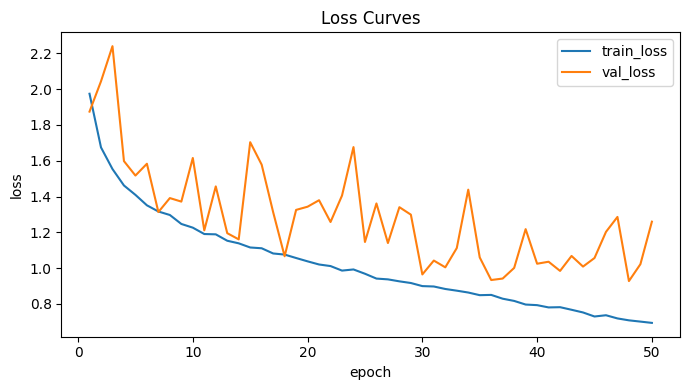

   [SAVE] ./runs/cnn\analysis_figs\loss_curves.png


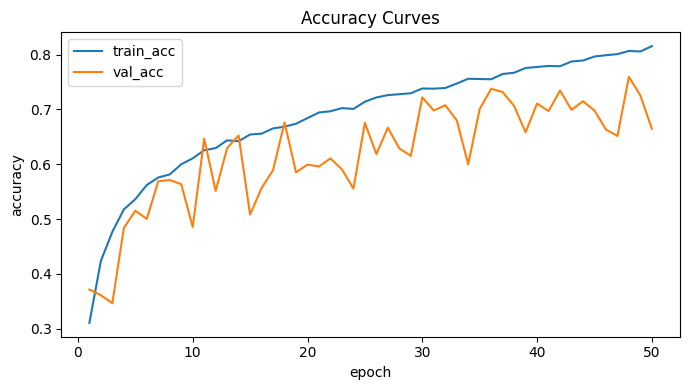

   [SAVE] ./runs/cnn\analysis_figs\accuracy_curves.png


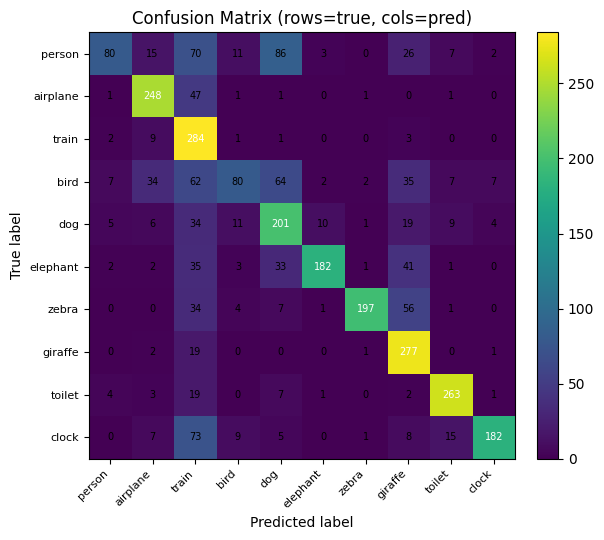

   [SAVE] ./runs/cnn\analysis_figs\confusion_matrix_labels.png

[PER-CLASS SUMMARY] (precision / recall / f1)
 -          person: 0.792 / 0.267 / 0.399
 -        airplane: 0.761 / 0.827 / 0.792
 -           train: 0.419 / 0.947 / 0.581
 -            bird: 0.667 / 0.267 / 0.381
 -             dog: 0.496 / 0.670 / 0.570
 -        elephant: 0.915 / 0.607 / 0.729
 -           zebra: 0.966 / 0.657 / 0.782
 -         giraffe: 0.593 / 0.923 / 0.722
 -          toilet: 0.865 / 0.877 / 0.871
 -           clock: 0.924 / 0.607 / 0.732

[MACRO AVG] precision 0.740 / recall 0.665 / f1 0.656


In [20]:
# 0) 설정
SAVE_FIGS = True
SEARCH_DIRS = [
    ".",                      # 현재 폴더
    "./runs/cnn",             # 학습 스크립트 기본 저장 폴더
    "./data_csv",             # 데이터 루트
    "./data_csv/meta",        # 샘플링 CSV 위치(권장)
    "/mnt/data"               # 노트북/서버 환경
]

# 1) 라이브러리
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2) 공용 유틸: 파일 경로 탐색
def find_path(filename: str, search_dirs):
    for d in search_dirs:
        p = os.path.join(d, filename)
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {filename}\n검색경로: {search_dirs}")

# 3) 라벨명 매핑 로더
#   - 우선순위: (A) train_sampled.csv → (B) train_val_sampled.csv → (C) train_val.csv
#   - 매핑 규칙: 한 정수 라벨(label) ↔ 하나의 semantic_label(문자열)
def load_idx_to_class(search_dirs):
    candidates = [
        "train_sampled.csv",
        "train_val_sampled.csv",
        "train_val.csv",
    ]
    csv_path = None
    for name in candidates:
        try:
            csv_path = find_path(name, search_dirs)
            df = pd.read_csv(csv_path)
            cols = set(df.columns.str.strip())
            if {"label", "semantic_label"}.issubset(cols):
                # 3-1. 일관성 검증: 한 label에 semantic_label이 1개만 존재해야 함
                check = df.groupby("label")["semantic_label"].nunique()
                if (check > 1).any():
                    # 불일치 감지 시 다음 후보로
                    continue
                # 3-2. 매핑 구성
                m = (
                    df[["label", "semantic_label"]]
                    .drop_duplicates()
                    .sort_values("label")
                )
                idx_to_class = dict(zip(m["label"].astype(int), m["semantic_label"].astype(str)))
                return idx_to_class, csv_path
        except Exception:
            pass
    # 3-3. 매핑 실패 시: 숫자 라벨 그대로 사용
    return None, None

# 4) 경로 확정 (필수 산출물 5종)
history_csv   = find_path("history.csv",        SEARCH_DIRS)
preds_npy     = find_path("val_preds_best.npy", SEARCH_DIRS)
labels_npy    = find_path("val_labels.npy",     SEARCH_DIRS)
best_ckpt     = find_path("best.weights.h5",    SEARCH_DIRS)
last_ckpt     = find_path("last.weights.h5",    SEARCH_DIRS)

# 5) 라벨명 매핑 준비
idx_to_class, mapping_src = load_idx_to_class(SEARCH_DIRS)

print("[INFO] 파일 경로 확인 완료")
print(" - history.csv       :", history_csv)
print(" - val_preds_best.npy:", preds_npy)
print(" - val_labels.npy    :", labels_npy)
print(" - best.weights.h5   :", best_ckpt)
print(" - last.weights.h5   :", last_ckpt)
print(" - label map source  :", mapping_src if mapping_src else "(매핑 없음 → 숫자 라벨 사용)")

# 6) 데이터 로드
hist   = pd.read_csv(history_csv)
preds  = np.load(preds_npy)
labels = np.load(labels_npy)

# 6-1) TensorFlow(Keras) 히스토리 컬럼 호환 처리
#      - loss → train_loss, accuracy/acc → train_acc, val_accuracy/val_acc → val_acc, epoch 추가
if "train_loss" not in hist.columns and "loss" in hist.columns:
    hist["train_loss"] = hist["loss"]
if "train_acc" not in hist.columns:
    if "accuracy" in hist.columns:
        hist["train_acc"] = hist["accuracy"]
    elif "acc" in hist.columns:
        hist["train_acc"] = hist["acc"]
if "val_acc" not in hist.columns:
    if "val_accuracy" in hist.columns:
        hist["val_acc"] = hist["val_accuracy"]
    elif "val_acc" in hist.columns:
        hist["val_acc"] = hist["val_acc"]  # 이미 있으면 그대로
if "epoch" not in hist.columns:
    hist["epoch"] = np.arange(1, len(hist) + 1, dtype=int)

# 7) 요약 정보
best_idx = int(hist["val_acc"].idxmax())
best_epoch = int(hist.loc[best_idx, "epoch"])
best_val_acc = float(hist.loc[best_idx, "val_acc"])
final_val_acc = float(hist["val_acc"].iloc[-1])
final_train_acc = float(hist["train_acc"].iloc[-1])

print("\n[SUMMARY]")
print(f" - epochs               : {int(hist['epoch'].max())}")
print(f" - best epoch (val acc) : {best_epoch}  | best val acc: {best_val_acc:.4f}")
print(f" - final train acc      : {final_train_acc:.4f}")
print(f" - final val   acc      : {final_val_acc:.4f}")

# 8) 그림 저장 헬퍼
def maybe_save(fig, fname: str):
    if SAVE_FIGS:
        out_dir = os.path.join(os.path.dirname(history_csv), "analysis_figs")
        os.makedirs(out_dir, exist_ok=True)
        path = os.path.join(out_dir, fname)
        fig.savefig(path, dpi=150, bbox_inches="tight")
        print(f"   [SAVE] {path}")

# 9) Loss 곡선
fig = plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["train_loss"], label="train_loss")
plt.plot(hist["epoch"], hist["val_loss"] if "val_loss" in hist.columns else hist["loss"], label="val_loss" if "val_loss" in hist.columns else "val_loss(?)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("Loss Curves")
plt.legend(); plt.tight_layout(); plt.show()
maybe_save(fig, "loss_curves.png")

# 10) Accuracy 곡선
fig = plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["train_acc"], label="train_acc")
plt.plot(hist["epoch"], hist["val_acc"],   label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.title("Accuracy Curves")
plt.legend(); plt.tight_layout(); plt.show()
maybe_save(fig, "accuracy_curves.png")

# 11) Learning Rate 곡선 
if "lr" in hist.columns:
    fig = plt.figure(figsize=(7,4))
    plt.plot(hist["epoch"], hist["lr"], label="lr")
    plt.xlabel("epoch"); plt.ylabel("learning rate")
    plt.title("Learning Rate")
    plt.legend(); plt.tight_layout(); plt.show()
    maybe_save(fig, "learning_rate.png")

# 12) Error Rate 곡선 
if "error_rate" in hist.columns:
    fig = plt.figure(figsize=(7,4))
    plt.plot(hist["epoch"], hist["error_rate"], label="error_rate")
    plt.xlabel("epoch"); plt.ylabel("error rate")
    plt.title("Error Rate")
    plt.legend(); plt.tight_layout(); plt.show()
    maybe_save(fig, "error_rate.png")

# 13) 혼동행렬(cm) 계산 (행=실제, 열=예측)
num_classes = int(max(preds.max(), labels.max())) + 1
num_classes = max(num_classes, 10)  # 안전: 최소 10개 가정
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(labels.astype(int), preds.astype(int)):
    if 0 <= t < num_classes and 0 <= p < num_classes:
        cm[t, p] += 1

# 14) 클래스 이름 준비 (라벨명 매핑 성공 시 → 문자열, 실패 시 → 숫자)
if idx_to_class:
    class_names = [idx_to_class.get(i, str(i)) for i in range(num_classes)]
else:
    class_names = [str(i) for i in range(num_classes)]

# 15) 혼동행렬 시각화 (라벨명 축 적용)
fig = plt.figure(figsize=(6.5, 5.5))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")    # 기본 colormap 사용
plt.title("Confusion Matrix (rows=true, cols=pred)")
plt.xlabel("Predicted label")
plt.ylabel("True label")

# 15-1) 축 눈금: 라벨명 사용
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right", fontsize=8)
ax.set_yticks(range(num_classes))
ax.set_yticklabels(class_names, fontsize=8)

# 15-2) 셀에 정수값 렌더링
thresh = cm.max() / 2.0 if cm.max() > 0 else 0
for i in range(num_classes):
    for j in range(num_classes):
        val = cm[i, j]
        ax.text(j, i, str(val),
                ha="center", va="center",
                color="white" if val > thresh else "black", fontsize=7)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()
maybe_save(fig, "confusion_matrix_labels.png")

# 16) 클래스별 precision / recall / f1 요약
TP = np.diag(cm).astype(float)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
precision = np.divide(TP, TP+FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
recall    = np.divide(TP, TP+FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(TP), where=(precision+recall)!=0)

print("\n[PER-CLASS SUMMARY] (precision / recall / f1)")
for c in range(num_classes):
    name = class_names[c]
    print(f" - {name:>15s}: {precision[c]:.3f} / {recall[c]:.3f} / {f1[c]:.3f}")

# 전체 지표도 참고
macro_p = precision.mean()
macro_r = recall.mean()
macro_f = f1.mean()
print(f"\n[MACRO AVG] precision {macro_p:.3f} / recall {macro_r:.3f} / f1 {macro_f:.3f}")


### 🔍 **해석 가이드**

#### 📊 **1. Loss Curves (손실 곡선)**
- **정의**: 모델이 예측한 값과 실제 정답(label) 간의 차이를 수치로 나타낸 값.
- **역할**: 모델 학습의 방향을 알려주는 **나침반** 역할.
- **특징**:
  - 값이 **작을수록** 예측이 정답에 가까움.
  - 학습 과정에서 Loss를 **최소화**하도록 가중치(파라미터)가 조정됨.
  - 예: 분류 문제 → `CrossEntropyLoss`, 회귀 문제 → `MSELoss`.
- **주의점**:
  - Loss가 낮아도 Accuracy가 반드시 높다는 뜻은 아님  
    (특히 클래스 불균형 데이터에서 자주 발생).

#### 📊 **2. Accuracy Curves (정확도 곡선)**
- **정의**: 전체 예측 중 **정답을 맞춘 비율**  
  $Accuracy = \frac{\text{정답 개수}}{\text{전체 데이터 개수}}$
- **역할**: 모델의 **전반적인 분류 성능** 평가.
- **특징**:
  - 값이 **1.0 (100%)**에 가까울수록 좋음.
  - 직관적이라 초보자도 이해하기 쉽지만, **데이터 불균형** 상황에서는 신뢰하기 어려움.  
    (예: 데이터의 90%가 동일한 클래스일 때, 해당 클래스로 전부 예측해도 다른 클래스는 모두 틀렸지만 Accuracy=90%).

#### 📊 **3. Learning Rate (학습률 곡선)**
- **정의**: 학습 시 가중치(weight)를 얼마나 크게 업데이트할지 결정하는 **하이퍼파라미터**.
- **역할**: 학습의 속도와 안정성을 제어.
- **특징**:
  - **너무 크면** → 최적점을 지나쳐 발산하거나 불안정해짐.
  - **너무 작으면** → 학습이 매우 느려지거나 최적점에 도달하지 못함.
  - 적절한 학습률은 빠르고 안정적인 수렴을 가능하게 함.
  - 일정 에폭마다 감소시키는 스케줄링 기법(`StepLR`, `ReduceLROnPlateau` 등) 또는 자동 조절 옵티마이저(`Adam`, `RMSProp`)를 사용하기도 함.
  - 언덕을 내려갈 때 한 번에 너무 크게 뛰면 넘어지고, 너무 작게 움직이면 제자리걸음이 되는 것과 유사.
  - **이번 실습**에서는 `CosineAnnealingLR` 스케줄러 사용 → 학습률이 점점 줄어들며 안정적으로 수렴하도록 도움.

#### 📊 **4. Error Rate (오차율 곡선)**
- **정의**: Accuracy의 보완 지표, 전체 예측 중 **틀린 비율**  
  \[
  Error\ Rate = 1 - Accuracy
  \]
- **역할**: 모델의 실패 사례 비율 확인.
- **특징**:
  - 값이 **작을수록** 좋음.
  - Accuracy와 반대 개념, 두 값을 함께 보면 모델 성능을 직관적으로 이해 가능.
  - 예: Accuracy=0.92 → Error Rate=0.08

#### 📑 **5. 혼동 행렬(Confusion Matrix)**
- **정의**: 학습 간 모델이 예측한 라벨과 실제 정답 라벨을 **행렬의 형태**로 시각화
  - **행(Row)** = 실제 정답 라벨.
  - **열(Col)** = 모델이 예측한 라벨.
- **역할**: 어떤 클래스끼리 혼동이 많이 발생하는지 확인 → 데이터 보강, 모델 개선 방향 설정 가능.
- **특징**:
  - **대각선(↘)** 값이 높을수록 해당 클래스의 예측이 정확함.
  - 대각선 외 값은 **다른 클래스로 잘못 예측**한 경우를 의미.
  - 잘못 예측한 경우가 특히나 많을 경우, **해당 클래스의 데이터를 보강**하는 게 좋음.


# **5. 모델 예측 및 실무 활용**

# **5.1 모델 예측**

모델 예측은 학습된 모델을 **새로운 데이터셋에 적용**하는 과정입니다.

검증과 방식은 유사하나 그 대상이 다른 만큼 훨씬 객관적이고 현실적인 성능 평가가 가능합니다.

🔹&nbsp;**모델 예측의 명확한 이해**

앞선 과정에서 모델을 학습시키고, 학습 데이터와 별도로 분리된 검정 데이터를 사용해 성능을 평가했습니다.

하지만 이 검정 데이터는 학습 데이터와 같은 데이터셋에서 분리된 것으로, 동일한 classes 구조와 유사한 라벨링 방식을 따릅니다.

즉, 모델은 여전히 **익숙한 유형의 데이터**에서 성능을 평가받은 것이고, 이는 정답을 외워 문제를 푸는 상황과 유사합니다.

실무에서는 이런 데이터가 아닌, 완전히 새로운 환경에서 수집된 데이터를 다루게 됩니다. 

따라서 학습된 모델이 현실에서도 잘 작동하는지를 확인하려면 새로운 데이터에 대한 예측을 반드시 거쳐야 합니다.

해당 과정이 바로 모델 예측입니다.

아래의 코드를 통해 100장 가량의 예측용 이미지를 즉시 업로드 및 압축 해제하고, 4장에서 학습한 모델로 모델 예측을 시행할 수 있습니다.

In [21]:
import requests, zipfile, os

# 1. GitHub Release에서 data_predict.zip 다운로드
url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/download/CNN_release-2025/data_predict.zip"

with open("data_predict.zip", "wb") as f:
    f.write(requests.get(url).content)

# 2. 압축 해제
with zipfile.ZipFile("data_predict.zip", 'r') as zip_ref:
    zip_ref.extractall("data_predict")

# 3. 결과 확인
print("✅ 예측용 이미지 압축 해제 완료:", os.listdir("data_predict"))

✅ 예측용 이미지 압축 해제 완료: ['data_predict', 'Labels.csv']


아래의 코드에서 압축 해제한 예측용 이미지에 대해 **모델 예측**을 진행할 수 있습니다.

예측용 데이터셋에는 학습용 데이터셋에는 없던 클래스가 몇 가지 존재합니다.

아래의 코드에서 압축 해제한 예측용 이미지에 대해 **모델 예측**을 진행할 수 있으며, 예측 결과가 라벨링된 이미지가 출력되어
**해당 이미지의 원본 클래스와 예측 클래스가 동일** 한지, 존재하지 않는 클래스를 모델이 이미지를 어떻게 인식하고 있는지 확인해볼 수 있습니다.

Model loaded: runs/cnn/best_model.keras


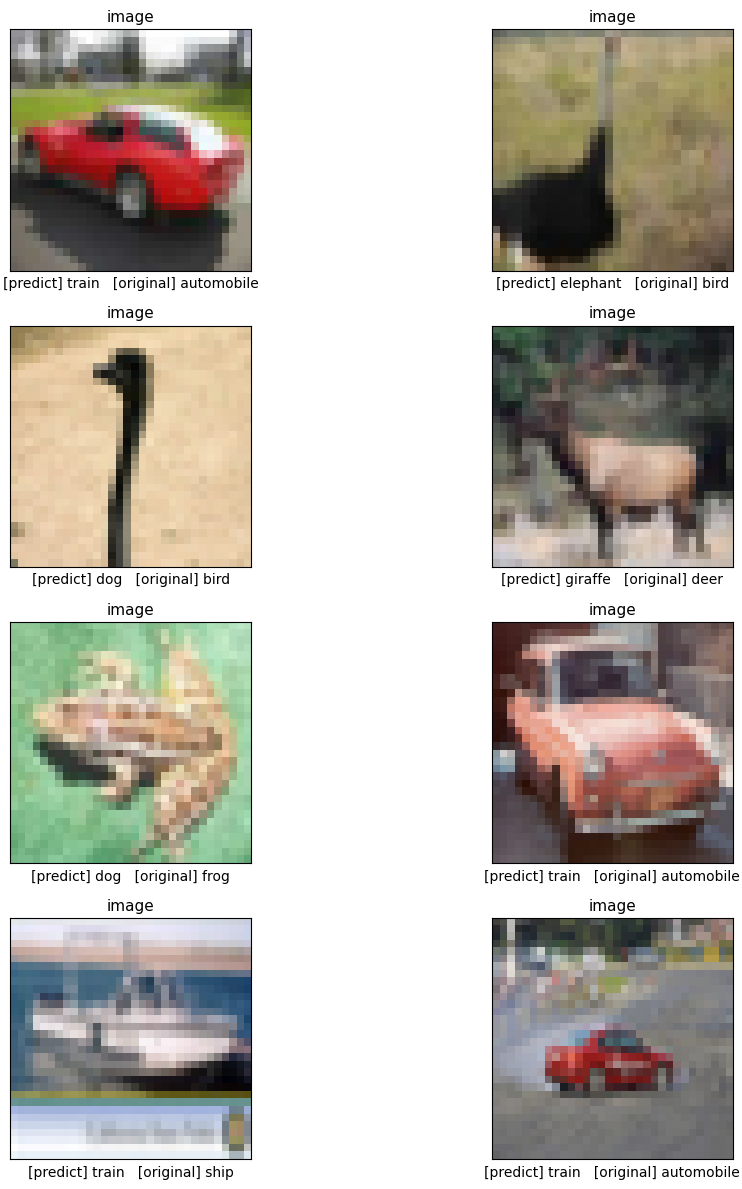

In [24]:
# -*- coding: utf-8 -*-
# 0) 기본 설정
PREDICT_CSV = "data_predict/Labels.csv"       # 열: id, label
PREDICT_DIR = "data_predict/data_predict"     # 예측용 이미지 폴더
OUT_DIR     = "runs/predict"                  # 결과 저장 폴더
# 로드 우선순위: 전체 모델(.keras) → 가중치(best) → 가중치(last)
CANDIDATE_MODELS = [
    "runs/cnn/best_model.keras",
    "runs/cnn/best.weights.h5",
    "runs/cnn/last.weights.h5",
]
import os
os.makedirs(OUT_DIR, exist_ok=True)

# 1) 라이브러리
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# 2) 전처리(학습과 동일하게 유지)
IMG_SIZE = (128, 128)
IM_MEAN = tf.constant([0.485, 0.456, 0.406], tf.float32)
IM_STD  = tf.constant([0.229, 0.224, 0.225], tf.float32)

def _preprocess_pil(img_pil):
    # PIL 이미지를 텐서로 변환 → 리사이즈 → 정규화 → 배치 차원 추가
    x = tf.convert_to_tensor(np.array(img_pil), dtype=tf.float32) / 255.0
    x = tf.image.resize(x, IMG_SIZE)
    x = (x - IM_MEAN) / IM_STD
    x = tf.expand_dims(x, 0)
    return x

# 3) 학습용 라벨 이름 로드(예측 표시용)
#    우선순위: data_csv/meta/train_sampled.csv → train_val_sampled.csv → train_val.csv
def _find_first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def _load_train_idx_to_name():
    candidates = [
        "data_csv/meta/train_sampled.csv",
        "data_csv/meta/train_val_sampled.csv",
        "data_csv/train_val.csv",
    ]
    path = _find_first_existing(candidates)
    if path is None:
        return None
    df = pd.read_csv(path)
    cols = set(df.columns.str.strip())
    if {"label", "semantic_label"}.issubset(cols):
        # 한 정수 라벨에 하나의 이름만 매칭되는지 확인
        check = df.groupby("label")["semantic_label"].nunique()
        if (check > 1).any():
            return None
        m = (df[["label","semantic_label"]]
             .drop_duplicates()
             .sort_values("label"))
        return {int(r.label): str(r.semantic_label) for _, r in m.iterrows()}
    return None

TRAIN_IDX_TO_NAME = _load_train_idx_to_name()

# 4) 모델 준비/로드
def _build_v1_baseline_softmax(num_classes=10, wd=1e-4, dropout_p=0.3):
    L2 = tf.keras.regularizers.l2
    def _conv_bn_relu(x, filters, wd=None):
        x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False,
                                   kernel_regularizer=L2(wd) if wd else None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        return x
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = _conv_bn_relu(inputs, 32, wd); x = _conv_bn_relu(x, 32, wd); x = tf.keras.layers.MaxPooling2D()(x)
    x = _conv_bn_relu(x, 64, wd);      x = _conv_bn_relu(x, 64, wd); x = tf.keras.layers.MaxPooling2D()(x)
    x = _conv_bn_relu(x, 128, wd);     x = _conv_bn_relu(x, 128, wd);x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_p)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax",
                                    kernel_regularizer=L2(wd) if wd else None)(x)
    return tf.keras.Model(inputs, outputs, name="cnn_v1_baseline")

def _load_model():
    # 존재하는 첫 모델 파일 선택
    chosen = None
    for p in CANDIDATE_MODELS:
        if os.path.exists(p):
            chosen = p
            break
    if chosen is None:
        raise FileNotFoundError(f"No model file found in: {CANDIDATE_MODELS}")
    # .keras이면 전체 모델 로드, 아니면 동일 구조를 빌드 후 가중치 로드
    if chosen.endswith(".keras"):
        return tf.keras.models.load_model(chosen), chosen
    model = _build_v1_baseline_softmax(num_classes=10, wd=1e-4, dropout_p=0.3)
    model.load_weights(chosen)
    return model, chosen

model, USED_CKPT = _load_model()
model.trainable = False
print("Model loaded:", USED_CKPT)

# 5) 예측 CSV 로드(예측용 데이터셋의 실제 라벨 이름은 여기서 사용)
df = pd.read_csv(PREDICT_CSV)
df["filename"] = df["id"].astype(str) + ".png"

# 예측용 데이터셋의 라벨 이름 목록(원본 표시용)
ORIG_CLASSES = sorted(df["label"].astype(str).unique().tolist())
ORIG_TO_IDX  = {c:i for i,c in enumerate(ORIG_CLASSES)}
df["y_true_idx"] = df["label"].astype(str).map(ORIG_TO_IDX).astype(int)

# 6) 이미지 경로 해석(확장자/중복 경로 대비)
by_name, by_stem = {}, {}
for root, _, files in os.walk(PREDICT_DIR):
    for fn in files:
        full = os.path.join(root, fn)
        by_name[fn] = full
        stem, _ = os.path.splitext(fn)
        if stem not in by_stem:
            by_stem[stem] = full

def resolve_path(row):
    raw_id = str(row["id"]).strip().replace("\\","/").split("/")[-1]
    stem, ext = os.path.splitext(raw_id)
    cand = []
    cand.append(os.path.basename(str(row["filename"])))
    if ext: cand.append(os.path.basename(raw_id))
    cand += [f"{stem}{e}" for e in [".png",".jpg",".jpeg",".bmp",".tif",".tiff"]]
    for name in cand:
        if name in by_name: return by_name[name]
        st, _ = os.path.splitext(name)
        if st in by_stem:  return by_stem[st]
    return None

# 7) 예측 대상 수집(path, 원본 라벨 인덱스)
candidates = []
for _, r in df.iterrows():
    fp = resolve_path(r)
    if fp is not None:
        candidates.append((fp, r["y_true_idx"]))

# 8) 실행할 때마다 무작위로 8장 선택
rng = np.random.default_rng()  # 시드 고정 없음 → 매 실행마다 다르게 선택
k = min(8, len(candidates))
idx = rng.choice(len(candidates), size=k, replace=False) if k > 0 else []
sample_list = [candidates[i] for i in idx]

# 9) 단일 이미지 예측(소프트맥스 확률 → argmax)
def predict_one(path):
    with Image.open(path).convert("RGB") as im:
        x = _preprocess_pil(im)
    probs = model(x, training=False).numpy()[0]
    pred  = int(np.argmax(probs))
    return pred

# 10) 라벨 이름 해석
def _train_name(idx):
    # 모델은 학습용 데이터셋 라벨 체계로 예측 → 학습 라벨 이름 출력
    if isinstance(TRAIN_IDX_TO_NAME, dict) and (idx in TRAIN_IDX_TO_NAME):
        return TRAIN_IDX_TO_NAME[idx]
    return str(idx)

def _orig_name(idx):
    # 원본 라벨은 예측용 CSV에서의 실제 라벨 이름 출력
    return ORIG_CLASSES[idx] if 0 <= idx < len(ORIG_CLASSES) else str(idx)

# 11) 2×4 시각화(영문 레이블)
rows, cols = 4, 2
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = axs.flatten()
for i in range(rows*cols):
    ax = axs[i]
    if i < len(sample_list):
        fp, y_true_idx = sample_list[i]
        ax.imshow(Image.open(fp).convert("RGB"))
        ax.set_title("image", fontsize=11)
        y_pred = predict_one(fp)
        pred_name = _train_name(y_pred)     # 학습 라벨 이름
        true_name = _orig_name(y_true_idx)  # 예측용 데이터셋의 실제 라벨 이름
        ax.set_xlabel(f"[predict] {pred_name}   [original] {true_name}", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
    else:
        ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "preview_8.png"), dpi=150, bbox_inches="tight")
plt.show()

# **5.2 실무 활용**

CNN은 이미지 전체가 **어떤 클래스인지를 판별**하는 데 특화되어 있습니다.
<br>👉 따라서 실무에서는 **단일 이미지가 어떤 종류인가?** 를 결정하는 문제에 많이 쓰입니다.

- **🏥 의료계열 자료 판독** : X-ray, CT, MRI 사진을 입력 → 종양 유무, 질병 여부 분류

- **🖼️ 제품 불량 검사** : 공장 라인에서 촬영된 부품 사진 → 정상/불량 분류

- **📷 이미지 검색 및 추천** : 사진을 분류해서 비슷한 사진끼리 묶거나 추천 시스템에 활용

- **🧬 생물학 데이터 분석** : 세포/조직 이미지 분류, 현미경 영상 분석

<img src="https://i.imgur.com/GftONVM.png" style="height:500px;">